In this chapter, image segmentation is covered in detail. for object detection task, there is an keras example which needs to be covered.

Image segmentation - segment the image into multiple zones ['foreground, 'background', 'road', 'sidewalk' etc] at the pixel level.
Used to power applications in video editing, autonomous vehicles, robotics, medical imaging.
Again image segmentation can be classified as:
1. Semantic segmentation : find the generic categories of objects in an image .say there are two dogs in an image - both dogs are classified as dog
2. Instance segmentation : both the dogs are segmented separately giving them class 1 and class 2

For semantic segmentaion we use the oxford-IIIT dataset , where the output is a segmentation mask of shape same as input image and the value of each pixel is an integer label - 1. Foreground, 2. Background and 3. Contour.

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz


--2024-03-15 08:25:22--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-03-15 08:25:22--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-03-15 08:25:23--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

The dataset folder contains the input images and annotation (which is a mask of same size as input image and reveals details as to whether the pixel is foreground , background or contour)

In [2]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_image_paths = sorted([os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith('jpg')])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('png') and not fname.startswith('.')])

In [3]:
len(input_image_paths), len(target_paths)

(7390, 7390)

Visualize a sample image

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

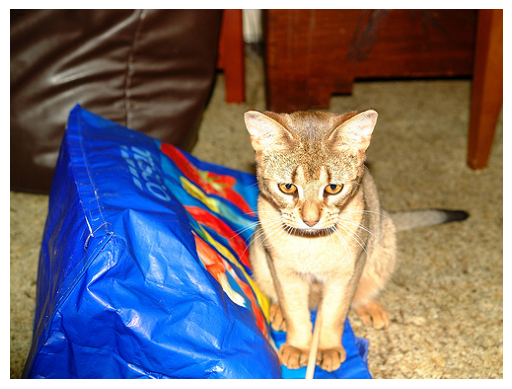

In [5]:
plt.axis("off")
plt.imshow(load_img(input_image_paths[7]))

In [6]:
def display_target(target_array):
  normalized_array = (target_array.astype('uint8') - 1)*127
  plt.axis('off')
  plt.imshow(normalized_array[:,:,0])

(375, 500, 1)


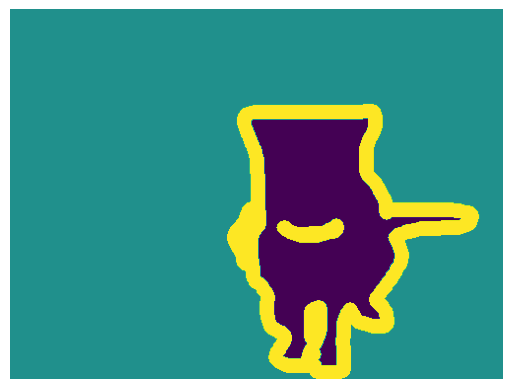

In [7]:
img = img_to_array(load_img(target_paths[7],color_mode='grayscale'))
print(img.shape)
display_target(img)

Dataset creation

In [8]:
import numpy as np
import random
img_size = (200,200) # input image and annotation to be resized to this resolution
num_imgs = len(input_image_paths)
#Shuffle the images and annotations
random.Random(1337).shuffle(input_image_paths)
random.Random(1337).shuffle(target_paths)

In [9]:
def path_to_image(path):
  return img_to_array(load_img(path, target_size=img_size))


In [10]:
def path_to_targets(path):
  img = img_to_array(load_img(path, target_size=img_size,color_mode='grayscale'))
  img = img.astype('uint8') - 1 # the original integer labels are 1,2,3 .We subtract 1 to make it 0,1,2
  return img

In [11]:
input_imgs = np.zeros((num_imgs,)+img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,)+img_size+(1,), dtype=np.uint8)
for i in range(num_imgs):
  input_imgs[i] = path_to_image(input_image_paths[i])
  targets[i] = path_to_targets(target_paths[i])

In [12]:
len(input_imgs),len(targets)

(7390, 7390)

In [13]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [14]:
train_input_imgs.shape

(6390, 200, 200, 3)

Next comes the important part: Define the model and train it

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
def get_img_model(img_size,num_classes):
  inputs = keras.Input(shape=(img_size)+(3,))
  x = layers.Rescaling(1./255) (inputs)

  x = layers.Conv2D(64, kernel_size=3, strides=2, activation="relu", padding="same") (x) # padding is same instead of valid, meaning padding is added to preserve the shape of the input feature. also a stride of 2 is used unlike classification model
  x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same") (x)
  x = layers.Conv2D(128, kernel_size=3, strides=2, activation="relu", padding="same") (x)
  x =  layers.Conv2D(128, kernel_size=3, activation="relu", padding="same") (x)
  x = layers.Conv2D(256, kernel_size=3, strides=2, activation="relu", padding="same") (x)
  x =  layers.Conv2D(256, kernel_size=3,  activation="relu", padding="same") (x)
  #end of conv blocks
  x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same') (x)
  x = layers.Conv2DTranspose(256, 3, strides=2,activation='relu', padding='same') (x)
  x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same') (x)
  x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same') (x)
  x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same') (x)
  x = layers.Conv2DTranspose(64, 3, strides=2,activation='relu', padding='same') (x)
  outputs = layers.Conv2D(num_classes, 3, activation='softmax',padding='same') (x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model




In [17]:
model = get_img_model(img_size=img_size,num_classes=3)


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5",
                                    save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets, epochs=25,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/25
100/100 [==============================] - 112s 873ms/step - loss: 0.9396 - val_loss: 0.8965
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 61s 612ms/step - loss: 0.8774 - val_loss: 0.8648
Epoch 3/25
100/100 [==============================] - 62s 620ms/step - loss: 0.8555 - val_loss: 0.8388
Epoch 4/25
100/100 [==============================] - 62s 618ms/step - loss: 0.8078 - val_loss: 0.7648
Epoch 5/25
100/100 [==============================] - 62s 620ms/step - loss: 0.7788 - val_loss: 0.7634
Epoch 6/25
100/100 [==============================] - 62s 622ms/step - loss: 0.7640 - val_loss: 0.7428
Epoch 7/25
100/100 [==============================] - 62s 620ms/step - loss: 0.7520 - val_loss: 0.7804
Epoch 8/25
100/100 [==============================] - 62s 621ms/step - loss: 0.7361 - val_loss: 0.7073
Epoch 9/25
 83/100 [=======================>......] - ETA: 9s - loss: 0.7177 

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()


Model architecture design:
the first half of the neural network is very similar to classification model. It is a stack of conv2D layers with increasing number of filters which are feature maps encoding spatial features from the input image. The difference is that instead of using maxpool2D to downsample the image, we are using a stride of 2 with convolutions to downsample. For classification , the object is to learn features which help learn the classes. There is no need to encode exact spatial location with respect to its neighbouring pixels. we only needed the maximal activation coming out of a kernel window.
But in this case, the final required output is the segmentation mask for each pixel.Hence we need the spatial location of each pixel with respect to its neighbouring pixels.

the second half of the convolution net is opposite of what first half does. the final target resolution is the same as input image. So, we need to scale back to the original resolution.so we use the conv2d transpose to scale back up layer by layer reaching the input image resolution.
The final layer is a conv2D again of kernel size and 200,200 img size but with a softmax activation which produces scores for each filter and the one with maximum is then taken to compare with targets.

Inference on a sample test image

In [ ]:
from tensorflow.keras.utils import array_to_img
i=4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

In [ ]:
def display_mask(pred):
  mask=np.argmax(pred,axis=-1)
  mask*=127
  plt.axis("off")
  plt.imshow(mask)

In [ ]:
display_mask(mask)

The output mask looks pretty cool and accurate tbh!

Residual blocks : To solve the vanishing gradient problem in deep neural nets, residual skip connections are introduced which basically creates a direct route from input to output skipping over the computation, therebby providing a channel for flow of gradients without introduction of noise which could potentially be destructive in very deep neural nets.

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

In [11]:
def residual_block(x,filters,pooling=False):
  residual = x
  x = layers.Conv2D(filters,kernel_size=3, activation="relu",padding="same") (x)
  x = layers.Conv2D(filters,kernel_size=3, activation="relu",padding="same") (x)
  if pooling:
    x = layers.MaxPooling2D(2, padding="same") (x)
    residual = layers.Conv2D(filters,kernel_size=1, strides=2, padding="same") (residual)
  elif filters!=residual.shape[-1]:
    residual = layers.Conv2D(filters,kernel_size=1, padding="same") (residual)
  x = layers.add([x,residual])
  return x


In [13]:
x = residual_block(x,filters=32,pooling=True)
x = residual_block(x, filters=64,pooling=True
                   )
x = residual_block(x, filters=128,pooling=True)
x = layers.GlobalAveragePooling2D() (x) # used instead of Flatten() and another dense layer , this returns the average of values for each feature map
outputs = layers.Dense(1, activation ='sigmoid') (x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 32, 32, 32)           896       ['rescaling[0][0]']           
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 32)           9248      ['conv2d_2[0][0]']            
                                                                                              

with residual connections , networks of arbitraty depths can be built without worrying much about vanishing gradients.
The next important breakthrough in training deep neural networks was batch-normalization. The initilization of weights is done now using set_weights("random_initializer") , but this was a carefully done exercise to make sure that the weights were well distributed in the range of -1,1 and the effect these weights could have after passing through dense layers with activation was also considered. Hence a factor 1/sqrt(nd**2), where nd is the size of input to layer. this gave better performance and depending on the activation , an additional constant was added.
The introduction of batch-norm fixed the effect of initialization of weights to a certain extent.

Batchnormalization has two ways of being called
x = layers.Conv2D(32,3,activation="relu") (x)
x = layers.BatchNormalization()(x)
this is not recommended by the author. 
Instead
x = layers.Conv2D(32,3,use_bias=False) (x)
x = layers.BatchNormalization () (x)
x = layers.Activation("relu") (x)
After batch normalization , we put the activation
Intuitively, we do this because the batch norm will center the tensor to zero and then applying relu on it
will be effective
But this can be used either way and there is no considerabe difference

while finetuning a model on custom dataset, batch_norm is disabled from training, because it will then change the mean and variance, which might interfere with the surrounding conv2D layers.


Depthwise separable convolution layers :
leaner, smaller conv model which sometimes gives higher percentage points
Spatial convolution on each channel independently and then do point-wise convolution on the resultant outputs.

-> use a deep and narrow block instead of shallow and broad
-> use multiple blocks , with two to three conv layers and 1 Maxpool layer
-> use skip connections [residual blocks] to prevent vanishing gradients
->  introduce batch norm to prevent internal covariate shift
-> Use separable conv2D layers instead of conv2D layers.

Xception architecture



In [14]:
data_augmentation = keras.Sequential(
            [
               layers.RandomFlip("horizontal"),
               layers.RandomRotation(0.1),
               layers.RandomZoom(0.2),
] )

In [22]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255) (x)
x = layers.Conv2D(32, kernel_size=5,use_bias=False ) (x)
for size in [32,64,128,256,512]:
    residual = x
    x = layers.BatchNormalization() (x)
    x = layers.Activation("relu") (x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization() (x)
    x = x = layers.Activation("relu") (x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x= layers.MaxPooling2D(3,strides = 2, padding="same") (x)
    residual = layers.Conv2D(size,kernel_size=1,strides = 2,padding="same",use_bias=False) (residual)
    x = layers.add([x, residual])
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dropout(0.5) (x)
outputs= layers.Dense(1, activation="sigmoid") (x)
model = keras.Model(inputs = inputs, outputs=outputs)



In [23]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_6[0][0]']             
                                                                                                  
 rescaling_5 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[4][0]']          
                                                                                                  
 conv2d_35 (Conv2D)          (None, 176, 176, 32)         2400      ['rescaling_5[0][0]']         
                                                                                            

Explanation of num_parameters [for the sake of clarity in operation of the model]
conv2d_35 (Conv2D) : A normal convolution with 5X5 kernel window and use_bias = False
So, the number of parameters is 5X5X3X32 = 2400
Batch normalization : the convolution has a unique property , the shared filters are applied over every spatial location, hence there is no need to calculate mean and variance along the batch axis alone, instead mean and variance are calculated along the B, H, W axes and in the end 'C' means and variance are taken as parameters
So, the number of paramters for batch_norm = 32X4 = 128 , where out of the 4, the moving average mean and moving average variance are non-learnable and updated during training, and scale and shift parameters are learned during training
separable_conv2d_22 : Depth wise separable convolution layers
num_params = 3X3X32 + 32X32 = 1312 parameters

Let us train this model on dogs vs cats dataset!

In [51]:
#Preparation of dataset
import os, shutil, pathlib
original_dir = pathlib.Path("dogs-vs-cats/train/")
new_base_dir = pathlib.Path("cats_vs_dogs_small/")



In [52]:
def make_subset(subset_name, start_index, end_index): 
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                    for i in range(start_index, end_index)] 
        for fname in fnames:
            #print(dir / fname)
            shutil.copyfile(src = original_dir / fname,dst = dir / fname)
        

In [54]:
make_subset("train", 0,1000)
make_subset("val",1000,1500)
make_subset("test",1500,2000)

In [55]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
new_base_dir / "train",
image_size=(180, 180),
batch_size=32)
validation_dataset = image_dataset_from_directory(
new_base_dir / "val",
image_size=(180, 180),
batch_size=32)
test_dataset = image_dataset_from_directory(
new_base_dir / "test",
image_size=(180, 180),
batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [56]:
callbacks = [
    keras.callbacks.ModelCheckpoint(

filepath="Xception_catsvdogs.h5",
save_best_only=True,
monitor="val_loss")
]

In [58]:
model.compile(loss="binary_crossentropy",
                      optimizer="rmsprop",
metrics=["accuracy"])

In [59]:
history = model.fit(
            train_dataset,
            epochs=30,
            validation_data=validation_dataset,
            callbacks=callbacks)

Epoch 1/30


2024-03-16 16:50:55.673516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-16 16:50:56.132646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.7850 - accuracy: 0.5781  

2024-03-16 16:51:02.221034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:02.364397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.9888 - accuracy: 0.5156

2024-03-16 16:51:02.503603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:02.625330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.9491 - accuracy: 0.4792

2024-03-16 16:51:02.761825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:02.883414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.8844 - accuracy: 0.5039

2024-03-16 16:51:03.004218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:03.121444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.8454 - accuracy: 0.5094

2024-03-16 16:51:03.246608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:03.368347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.8182 - accuracy: 0.5260

2024-03-16 16:51:03.490569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:03.609723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.7965 - accuracy: 0.5402

2024-03-16 16:51:03.731211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:03.850812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.7839 - accuracy: 0.5430

2024-03-16 16:51:03.969626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:04.091598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.7768 - accuracy: 0.5330

2024-03-16 16:51:04.208924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:04.327178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.7657 - accuracy: 0.5422

2024-03-16 16:51:04.448598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:04.566002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.7554 - accuracy: 0.5469

2024-03-16 16:51:04.683228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:04.800877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.7474 - accuracy: 0.5534

2024-03-16 16:51:04.918965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:05.036720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.7426 - accuracy: 0.5529

2024-03-16 16:51:05.158680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:05.284481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.7366 - accuracy: 0.5569

2024-03-16 16:51:05.403167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:05.521343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.7348 - accuracy: 0.5583

2024-03-16 16:51:05.639911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:05.758045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.7336 - accuracy: 0.5547

2024-03-16 16:51:05.878377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:05.998290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.7279 - accuracy: 0.5570

2024-03-16 16:51:06.117942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:06.235887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.7246 - accuracy: 0.5582

2024-03-16 16:51:06.353057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:06.471699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.7248 - accuracy: 0.5576

2024-03-16 16:51:06.589225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:06.707826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.7215 - accuracy: 0.5578

2024-03-16 16:51:06.823770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:06.944317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.7167 - accuracy: 0.5632

2024-03-16 16:51:07.066590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:07.187950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.7117 - accuracy: 0.5682

2024-03-16 16:51:07.306622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:07.425376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.7132 - accuracy: 0.5645

2024-03-16 16:51:07.545419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:07.666630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.7129 - accuracy: 0.5645

2024-03-16 16:51:07.783765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:07.906889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.7124 - accuracy: 0.5612

2024-03-16 16:51:08.025122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:08.144940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.7096 - accuracy: 0.5661

2024-03-16 16:51:08.262986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:08.379350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.7076 - accuracy: 0.5689

2024-03-16 16:51:08.495963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:08.611763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.7058 - accuracy: 0.5725

2024-03-16 16:51:08.728988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:08.844238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.7075 - accuracy: 0.5727

2024-03-16 16:51:08.961395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:09.076792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.7065 - accuracy: 0.5719

2024-03-16 16:51:09.200310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:09.320218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.7022 - accuracy: 0.5756

2024-03-16 16:51:09.440244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:09.559710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 18s 179ms/step - loss: 0.7015 - accuracy: 0.5765 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 2/30


/Users/divyeshkanagavel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-03-16 16:51:13.332879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.7251 - accuracy: 0.5469

2024-03-16 16:51:13.494917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:13.614144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.7232 - accuracy: 0.5703

2024-03-16 16:51:13.731727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:13.853786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.7163 - accuracy: 0.5365

2024-03-16 16:51:13.971842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:14.090588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.7103 - accuracy: 0.5312

2024-03-16 16:51:14.209174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:14.327078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.7037 - accuracy: 0.5281

2024-03-16 16:51:14.445707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:14.566577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.7004 - accuracy: 0.5391

2024-03-16 16:51:14.683481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:14.802316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.7017 - accuracy: 0.5469

2024-03-16 16:51:14.920974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:15.038995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.6970 - accuracy: 0.5527

2024-03-16 16:51:15.155151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:15.281935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.6963 - accuracy: 0.5521

2024-03-16 16:51:15.400372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:15.519649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.6942 - accuracy: 0.5594

2024-03-16 16:51:15.637282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:15.754215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.6908 - accuracy: 0.5611

2024-03-16 16:51:15.873727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:15.990908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.6901 - accuracy: 0.5573

2024-03-16 16:51:16.109143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:16.228739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.6840 - accuracy: 0.5709

2024-03-16 16:51:16.347459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:16.468603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.6861 - accuracy: 0.5714

2024-03-16 16:51:16.590714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:16.709943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.6799 - accuracy: 0.5802

2024-03-16 16:51:16.831016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:16.949156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.6797 - accuracy: 0.5742

2024-03-16 16:51:17.068913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:17.189505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.6793 - accuracy: 0.5744

2024-03-16 16:51:17.314670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:17.438769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.6794 - accuracy: 0.5755

2024-03-16 16:51:17.559323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:17.679443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.6758 - accuracy: 0.5806

2024-03-16 16:51:17.800594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:17.922002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.6777 - accuracy: 0.5797

2024-03-16 16:51:18.045001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:18.166380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.6760 - accuracy: 0.5863

2024-03-16 16:51:18.287743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:18.408684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.6730 - accuracy: 0.5866

2024-03-16 16:51:18.528801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:18.649333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.6714 - accuracy: 0.5876

2024-03-16 16:51:18.767955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:18.889325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6706 - accuracy: 0.5898

2024-03-16 16:51:19.009059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:19.127824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6712 - accuracy: 0.5875

2024-03-16 16:51:19.249653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:19.372779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.6713 - accuracy: 0.5871

2024-03-16 16:51:19.492964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:19.609859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.6709 - accuracy: 0.5897

2024-03-16 16:51:19.728515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:19.846909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.6717 - accuracy: 0.5893

2024-03-16 16:51:19.967283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:20.085066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6705 - accuracy: 0.5894

2024-03-16 16:51:20.203213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:20.324929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6701 - accuracy: 0.5896

2024-03-16 16:51:20.443363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:20.560731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.5927

2024-03-16 16:51:20.682191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:20.803909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 133ms/step - loss: 0.6696 - accuracy: 0.5925 - val_loss: 0.6928 - val_accuracy: 0.5040
Epoch 3/30
 1/63 [..............................] - ETA: 9s - loss: 0.6520 - accuracy: 0.5938

2024-03-16 16:51:21.739250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:21.896802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.6808 - accuracy: 0.6250

2024-03-16 16:51:22.019778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:22.141727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5938

2024-03-16 16:51:22.267579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:22.389314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.6687 - accuracy: 0.6027

2024-03-16 16:51:22.513129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:22.635441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6042

2024-03-16 16:51:22.758049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:22.881356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.6807 - accuracy: 0.5994

2024-03-16 16:51:23.006249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:23.128277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.6813 - accuracy: 0.5986

2024-03-16 16:51:23.246989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:23.369927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.6828 - accuracy: 0.6000

2024-03-16 16:51:23.490109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:23.613231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.6819 - accuracy: 0.5974

2024-03-16 16:51:23.734646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:23.858803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.6775 - accuracy: 0.5987

2024-03-16 16:51:23.986117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:24.120638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.6724 - accuracy: 0.6042

2024-03-16 16:51:24.255257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:24.396125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.6706 - accuracy: 0.5992

2024-03-16 16:51:24.528555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:24.659890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.6674 - accuracy: 0.6000

2024-03-16 16:51:24.786943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:24.909615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.6724 - accuracy: 0.5961

2024-03-16 16:51:25.031065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:25.152869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.6654 - accuracy: 0.6045

2024-03-16 16:51:25.274901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:25.400094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.6626 - accuracy: 0.6129

2024-03-16 16:51:25.523022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:25.648495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.6639 - accuracy: 0.6070

2024-03-16 16:51:25.775446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:25.903134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.6615 - accuracy: 0.6098

2024-03-16 16:51:26.026563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:26.150037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.6587 - accuracy: 0.6064

2024-03-16 16:51:26.273561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:26.398076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.6560 - accuracy: 0.6098

2024-03-16 16:51:26.526940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:26.656572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.6530 - accuracy: 0.6120

2024-03-16 16:51:26.781799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:26.907246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.6520 - accuracy: 0.6141

2024-03-16 16:51:27.030528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:27.154721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.6548 - accuracy: 0.6097

2024-03-16 16:51:27.279152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:27.401790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6538 - accuracy: 0.6070

2024-03-16 16:51:27.524429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:27.646125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6554 - accuracy: 0.6078

2024-03-16 16:51:27.769835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:27.892531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6547 - accuracy: 0.6097

2024-03-16 16:51:28.015229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:28.138239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.6522 - accuracy: 0.6120

2024-03-16 16:51:28.266892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:28.392798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6562 - accuracy: 0.6062

2024-03-16 16:51:28.518239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:28.644474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6551 - accuracy: 0.6069

2024-03-16 16:51:28.771571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:28.897430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.6065

2024-03-16 16:51:29.021302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:29.142315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6081

2024-03-16 16:51:29.265881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:29.389154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.6070

2024-03-16 16:51:29.513280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.6534 - accuracy: 0.6070 - val_loss: 0.6984 - val_accuracy: 0.5000
Epoch 4/30
 1/63 [..............................] - ETA: 11s - loss: 0.6148 - accuracy: 0.7500

2024-03-16 16:51:30.513178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:30.700316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.6756 - accuracy: 0.6042

2024-03-16 16:51:30.829304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:30.952738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.6802 - accuracy: 0.5875

2024-03-16 16:51:31.073076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:31.194698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.6594 - accuracy: 0.5938

2024-03-16 16:51:31.324494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:31.454914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.6634 - accuracy: 0.5868

2024-03-16 16:51:31.590334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:31.723191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.6695 - accuracy: 0.5767

2024-03-16 16:51:31.851742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:31.980072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.6710 - accuracy: 0.5697

2024-03-16 16:51:32.105133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:32.232194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.6622 - accuracy: 0.5771

2024-03-16 16:51:32.356426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:32.483496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.6589 - accuracy: 0.5864

2024-03-16 16:51:32.613329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:32.743442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.6636 - accuracy: 0.5806

2024-03-16 16:51:32.872704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:33.005232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.6586 - accuracy: 0.5923

2024-03-16 16:51:33.131661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:33.257536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.6557 - accuracy: 0.5992

2024-03-16 16:51:33.386000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:33.512198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.6565 - accuracy: 0.5975

2024-03-16 16:51:33.637765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:33.761868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.6564 - accuracy: 0.5926

2024-03-16 16:51:33.883974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:34.013855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.6556 - accuracy: 0.5916

2024-03-16 16:51:34.137304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:34.261982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.6583 - accuracy: 0.5907

2024-03-16 16:51:34.386945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:34.511304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.6605 - accuracy: 0.5928

2024-03-16 16:51:34.636965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:34.763465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.6612 - accuracy: 0.5929

2024-03-16 16:51:34.888050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:35.010037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.6564 - accuracy: 0.5971

2024-03-16 16:51:35.135407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:35.261667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.6529 - accuracy: 0.5994

2024-03-16 16:51:35.384458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:35.514303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.6483 - accuracy: 0.6052

2024-03-16 16:51:35.642292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:35.770149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.6484 - accuracy: 0.6039

2024-03-16 16:51:35.896477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:36.026844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.6517 - accuracy: 0.6000

2024-03-16 16:51:36.157214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:36.289579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.6517 - accuracy: 0.5991

2024-03-16 16:51:36.417260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:36.545250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6538 - accuracy: 0.5969

2024-03-16 16:51:36.674625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:36.809024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6506 - accuracy: 0.6023

2024-03-16 16:51:36.939798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:37.071681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.6505 - accuracy: 0.6032

2024-03-16 16:51:37.198802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:37.326642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.6506 - accuracy: 0.6011

2024-03-16 16:51:37.453652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:37.595578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6473 - accuracy: 0.6058

2024-03-16 16:51:37.734142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:37.864274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6445 - accuracy: 0.6070

2024-03-16 16:51:37.989589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:38.118476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6438 - accuracy: 0.6081

2024-03-16 16:51:38.243340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:38.370283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.6095

2024-03-16 16:51:38.495619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 142ms/step - loss: 0.6413 - accuracy: 0.6095 - val_loss: 0.7749 - val_accuracy: 0.5000
Epoch 5/30
 1/63 [..............................] - ETA: 10s - loss: 0.7855 - accuracy: 0.5000

2024-03-16 16:51:39.497802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:39.676352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.7084 - accuracy: 0.5938

2024-03-16 16:51:39.804646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:39.925965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.7026 - accuracy: 0.5938

2024-03-16 16:51:40.048664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:40.172965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6205

2024-03-16 16:51:40.294257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:40.425420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.6456 - accuracy: 0.6528

2024-03-16 16:51:40.555996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:40.686707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.6559 - accuracy: 0.6278

2024-03-16 16:51:40.814147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:40.943034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.6417 - accuracy: 0.6394

2024-03-16 16:51:41.070315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:41.197301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.6433 - accuracy: 0.6417

2024-03-16 16:51:41.323559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:41.449230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.6432 - accuracy: 0.6452

2024-03-16 16:51:41.574685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:41.699950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.6450 - accuracy: 0.6398

2024-03-16 16:51:41.822175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:41.947754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.6439 - accuracy: 0.6399

2024-03-16 16:51:42.075025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:42.200710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.6424 - accuracy: 0.6359

2024-03-16 16:51:42.325669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:42.453893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.6433 - accuracy: 0.6325

2024-03-16 16:51:42.585468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:42.714323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.6400 - accuracy: 0.6354

2024-03-16 16:51:42.842525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:42.964983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.6370 - accuracy: 0.6422

2024-03-16 16:51:43.088400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:43.213570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.6366 - accuracy: 0.6452

2024-03-16 16:51:43.337550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:43.459783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.6365 - accuracy: 0.6420

2024-03-16 16:51:43.583608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:43.708312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.6353 - accuracy: 0.6455

2024-03-16 16:51:43.829672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:43.950723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.6335 - accuracy: 0.6410

2024-03-16 16:51:44.075970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:44.200595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.6298 - accuracy: 0.6450

2024-03-16 16:51:44.326132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:44.452410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.6341 - accuracy: 0.6425

2024-03-16 16:51:44.575914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:44.699847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.6387 - accuracy: 0.6417

2024-03-16 16:51:44.822055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:44.945309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.6368 - accuracy: 0.6424

2024-03-16 16:51:45.072688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:45.195611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.6363 - accuracy: 0.6410

2024-03-16 16:51:45.320751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:45.442270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6353 - accuracy: 0.6429

2024-03-16 16:51:45.561161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:45.683860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6341 - accuracy: 0.6471

2024-03-16 16:51:45.803934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:45.925011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.6308 - accuracy: 0.6498

2024-03-16 16:51:46.044889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:46.165252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6308 - accuracy: 0.6494

2024-03-16 16:51:46.288632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:46.415988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6296 - accuracy: 0.6491

2024-03-16 16:51:46.539687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:46.662520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6286 - accuracy: 0.6488

2024-03-16 16:51:46.786990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:46.907871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.6465

2024-03-16 16:51:47.027459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:47.147874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.6485

2024-03-16 16:51:47.267412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 138ms/step - loss: 0.6280 - accuracy: 0.6485 - val_loss: 0.7230 - val_accuracy: 0.5000
Epoch 6/30
 1/63 [..............................] - ETA: 10s - loss: 0.5640 - accuracy: 0.6562

2024-03-16 16:51:48.249243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:48.432652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.6436 - accuracy: 0.5938

2024-03-16 16:51:48.558455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:48.678695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.6367 - accuracy: 0.6375

2024-03-16 16:51:48.798800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:48.924411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.6643 - accuracy: 0.6295

2024-03-16 16:51:49.047486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:49.166114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.6587 - accuracy: 0.6250

2024-03-16 16:51:49.289653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:49.412668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.6398 - accuracy: 0.6335

2024-03-16 16:51:49.538991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:49.664323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.6414 - accuracy: 0.6274

2024-03-16 16:51:49.791338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:49.920424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.6412 - accuracy: 0.6354

2024-03-16 16:51:50.048244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:50.174241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.6451 - accuracy: 0.6342

2024-03-16 16:51:50.300298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:50.429908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.6417 - accuracy: 0.6349

2024-03-16 16:51:50.554096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:50.678155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.6377 - accuracy: 0.6414

2024-03-16 16:51:50.798311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:50.925175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.6360 - accuracy: 0.6440

2024-03-16 16:51:51.049848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:51.173335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.6341 - accuracy: 0.6463

2024-03-16 16:51:51.297256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:51.419010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.6293 - accuracy: 0.6481

2024-03-16 16:51:51.546393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:51.672499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.6252 - accuracy: 0.6519

2024-03-16 16:51:51.794067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:51.916090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.6259 - accuracy: 0.6522

2024-03-16 16:51:52.036103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:52.158324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.6295 - accuracy: 0.6515

2024-03-16 16:51:52.281180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:52.409672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.6279 - accuracy: 0.6509

2024-03-16 16:51:52.534774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:52.657673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.6264 - accuracy: 0.6512

2024-03-16 16:51:52.781322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:52.904937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6227 - accuracy: 0.6538

2024-03-16 16:51:53.029030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:53.151103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.6280 - accuracy: 0.6471

2024-03-16 16:51:53.272862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:53.394482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.6268 - accuracy: 0.6497

2024-03-16 16:51:53.514978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:53.635508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.6235 - accuracy: 0.6500

2024-03-16 16:51:53.760907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:53.884235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6182 - accuracy: 0.6549

2024-03-16 16:51:54.017779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:54.145279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6153 - accuracy: 0.6562

2024-03-16 16:51:54.275621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:54.405494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6164 - accuracy: 0.6550

2024-03-16 16:51:54.535893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:54.668501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.6131 - accuracy: 0.6592

2024-03-16 16:51:54.794358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:54.915749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6159 - accuracy: 0.6574

2024-03-16 16:51:55.035944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:55.161216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6141 - accuracy: 0.6562

2024-03-16 16:51:55.286827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:55.412115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6128 - accuracy: 0.6573

2024-03-16 16:51:55.532050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:55.653625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6102 - accuracy: 0.6588

2024-03-16 16:51:55.775187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:55.896828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.6560

2024-03-16 16:51:56.022543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.6118 - accuracy: 0.6560 - val_loss: 0.7832 - val_accuracy: 0.5000
Epoch 7/30
 1/63 [..............................] - ETA: 10s - loss: 0.6873 - accuracy: 0.6875

2024-03-16 16:51:57.040729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:57.214630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.6115 - accuracy: 0.6771

2024-03-16 16:51:57.342331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:57.463167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.5735 - accuracy: 0.6875

2024-03-16 16:51:57.587972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:57.710487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.5768 - accuracy: 0.6830

2024-03-16 16:51:57.829580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:57.953164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.5848 - accuracy: 0.6806

2024-03-16 16:51:58.072955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:58.193703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.5899 - accuracy: 0.6790

2024-03-16 16:51:58.314687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:58.441744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.5916 - accuracy: 0.6755

2024-03-16 16:51:58.566075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:58.689537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.5897 - accuracy: 0.6771

2024-03-16 16:51:58.816827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:58.941746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.5878 - accuracy: 0.6728

2024-03-16 16:51:59.072880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:59.198428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.5919 - accuracy: 0.6694

2024-03-16 16:51:59.323202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:59.448592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.5861 - accuracy: 0.6741

2024-03-16 16:51:59.571742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:59.694801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.5890 - accuracy: 0.6739

2024-03-16 16:51:59.816788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:51:59.940594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.5880 - accuracy: 0.6775

2024-03-16 16:52:00.064000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:00.192704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.5865 - accuracy: 0.6817

2024-03-16 16:52:00.320604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:00.452015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.5903 - accuracy: 0.6821

2024-03-16 16:52:00.581068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:00.708995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.5872 - accuracy: 0.6855

2024-03-16 16:52:00.839975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:00.975372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.5949 - accuracy: 0.6809

2024-03-16 16:52:01.108283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:01.238272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.5936 - accuracy: 0.6812

2024-03-16 16:52:01.369134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:01.501160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.5920 - accuracy: 0.6816

2024-03-16 16:52:01.633756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:01.771129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.5870 - accuracy: 0.6859

2024-03-16 16:52:01.902853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:02.037843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.5848 - accuracy: 0.6905

2024-03-16 16:52:02.171372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:02.303310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.5840 - accuracy: 0.6890

2024-03-16 16:52:02.434163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:02.564392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.5871 - accuracy: 0.6868

2024-03-16 16:52:02.700538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:02.839384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.5907 - accuracy: 0.6848

2024-03-16 16:52:02.973674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:03.106136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5918 - accuracy: 0.6843

2024-03-16 16:52:03.239238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:03.373324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5936 - accuracy: 0.6869

2024-03-16 16:52:03.504086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:03.634622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.5915 - accuracy: 0.6881

2024-03-16 16:52:03.764620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:03.891159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.5892 - accuracy: 0.6892

2024-03-16 16:52:04.021977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:04.148104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5894 - accuracy: 0.6880

2024-03-16 16:52:04.275621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:04.407718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5895 - accuracy: 0.6870

2024-03-16 16:52:04.540074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:04.670242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.6849

2024-03-16 16:52:04.799031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:04.928990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.6840

2024-03-16 16:52:05.056967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 143ms/step - loss: 0.5922 - accuracy: 0.6840 - val_loss: 0.7528 - val_accuracy: 0.5010
Epoch 8/30
 1/63 [..............................] - ETA: 10s - loss: 0.5501 - accuracy: 0.7500

2024-03-16 16:52:06.062867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:06.242212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.5529 - accuracy: 0.7708

2024-03-16 16:52:06.376992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:06.500422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.5332 - accuracy: 0.7750

2024-03-16 16:52:06.627159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:06.753209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.5668 - accuracy: 0.7500

2024-03-16 16:52:06.877466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:07.009499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.5588 - accuracy: 0.7431

2024-03-16 16:52:07.143998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:07.277022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.5512 - accuracy: 0.7472

2024-03-16 16:52:07.408023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:07.540769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.5639 - accuracy: 0.7332

2024-03-16 16:52:07.668296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:07.795006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.5680 - accuracy: 0.7375

2024-03-16 16:52:07.920861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:08.048158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.5704 - accuracy: 0.7243

2024-03-16 16:52:08.172535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:08.300060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.5682 - accuracy: 0.7253

2024-03-16 16:52:08.429028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:08.560112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.5602 - accuracy: 0.7262

2024-03-16 16:52:08.688682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:08.825465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.5653 - accuracy: 0.7242

2024-03-16 16:52:08.958584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:09.092296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.5638 - accuracy: 0.7275

2024-03-16 16:52:09.226774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:09.360627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.5617 - accuracy: 0.7269

2024-03-16 16:52:09.492516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:09.624023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.5676 - accuracy: 0.7188

2024-03-16 16:52:09.757042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:09.882498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.5695 - accuracy: 0.7157

2024-03-16 16:52:10.010190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:10.141629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.5600 - accuracy: 0.7254

2024-03-16 16:52:10.272726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:10.396021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.5614 - accuracy: 0.7250

2024-03-16 16:52:10.519066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:10.642264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.5613 - accuracy: 0.7272

2024-03-16 16:52:10.766956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:10.898031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.5543 - accuracy: 0.7348

2024-03-16 16:52:11.027078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:11.154673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.5595 - accuracy: 0.7309

2024-03-16 16:52:11.282411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:11.415978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.5558 - accuracy: 0.7333

2024-03-16 16:52:11.558077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:11.697856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.5522 - accuracy: 0.7340

2024-03-16 16:52:11.828518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:11.958747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.5477 - accuracy: 0.7374

2024-03-16 16:52:12.089464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:12.214611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5484 - accuracy: 0.7366

2024-03-16 16:52:12.338625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:12.464327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5553 - accuracy: 0.7310

2024-03-16 16:52:12.588148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:12.714417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.5561 - accuracy: 0.7288

2024-03-16 16:52:12.840521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:12.969510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.5541 - accuracy: 0.7307

2024-03-16 16:52:13.097110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:13.226273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5545 - accuracy: 0.7297

2024-03-16 16:52:13.360351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:13.493031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5548 - accuracy: 0.7293

2024-03-16 16:52:13.627543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:13.764776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5540 - accuracy: 0.7290

2024-03-16 16:52:13.903830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:14.039946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7290

2024-03-16 16:52:14.174167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 146ms/step - loss: 0.5535 - accuracy: 0.7290 - val_loss: 0.6769 - val_accuracy: 0.5670
Epoch 9/30
 1/63 [..............................] - ETA: 10s - loss: 0.5883 - accuracy: 0.7500

2024-03-16 16:52:15.303852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:15.483217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.4949 - accuracy: 0.8125

2024-03-16 16:52:15.602103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:15.721897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.5416 - accuracy: 0.7625

2024-03-16 16:52:15.843098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:15.962859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.5390 - accuracy: 0.7455

2024-03-16 16:52:16.083827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:16.211501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.5385 - accuracy: 0.7431

2024-03-16 16:52:16.340344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:16.466426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.5415 - accuracy: 0.7301

2024-03-16 16:52:16.594678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:16.728656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.5361 - accuracy: 0.7332

2024-03-16 16:52:16.856887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:16.984993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.5480 - accuracy: 0.7333

2024-03-16 16:52:17.112086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:17.236862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.5534 - accuracy: 0.7298

2024-03-16 16:52:17.360344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:17.486119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.5549 - accuracy: 0.7253

2024-03-16 16:52:17.609817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:17.735145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.5479 - accuracy: 0.7307

2024-03-16 16:52:17.860014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:17.985750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.5450 - accuracy: 0.7364

2024-03-16 16:52:18.107041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:18.228796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.5455 - accuracy: 0.7362

2024-03-16 16:52:18.353739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:18.477250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.5458 - accuracy: 0.7338

2024-03-16 16:52:18.603315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:18.729223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.5434 - accuracy: 0.7338

2024-03-16 16:52:18.853874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:18.978066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.5482 - accuracy: 0.7319

2024-03-16 16:52:19.104364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:19.233510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.5439 - accuracy: 0.7367

2024-03-16 16:52:19.361749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:19.488774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.5440 - accuracy: 0.7366

2024-03-16 16:52:19.615728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:19.741224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.5420 - accuracy: 0.7390

2024-03-16 16:52:19.871726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:20.001802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.5417 - accuracy: 0.7412

2024-03-16 16:52:20.129989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:20.256040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.5379 - accuracy: 0.7447

2024-03-16 16:52:20.380532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:20.506248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.5362 - accuracy: 0.7449

2024-03-16 16:52:20.628297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:20.753414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.5402 - accuracy: 0.7417

2024-03-16 16:52:20.878684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:21.005653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.5356 - accuracy: 0.7427

2024-03-16 16:52:21.127445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:21.260587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5320 - accuracy: 0.7449

2024-03-16 16:52:21.389380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:21.517696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5334 - accuracy: 0.7451

2024-03-16 16:52:21.644461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:21.771860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.5310 - accuracy: 0.7465

2024-03-16 16:52:21.897693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:22.019172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.5311 - accuracy: 0.7455

2024-03-16 16:52:22.142042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:22.266887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5323 - accuracy: 0.7451

2024-03-16 16:52:22.392880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:22.517354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5334 - accuracy: 0.7426

2024-03-16 16:52:22.636801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:22.757963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5309 - accuracy: 0.7433

2024-03-16 16:52:22.880366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:23.003495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.7400

2024-03-16 16:52:23.125877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.5320 - accuracy: 0.7400 - val_loss: 1.4308 - val_accuracy: 0.5050
Epoch 10/30
 1/63 [..............................] - ETA: 10s - loss: 0.5155 - accuracy: 0.7500

2024-03-16 16:52:24.107472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:24.281116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.5370 - accuracy: 0.7292

2024-03-16 16:52:24.410857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:24.534551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.5185 - accuracy: 0.7437

2024-03-16 16:52:24.655007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:24.773260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.5014 - accuracy: 0.7634

2024-03-16 16:52:24.897526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:25.025975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.5159 - accuracy: 0.7361

2024-03-16 16:52:25.154742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:25.284254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.5300 - accuracy: 0.7386

2024-03-16 16:52:25.410483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:25.536644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.5140 - accuracy: 0.7596

2024-03-16 16:52:25.664085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:25.787033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.5109 - accuracy: 0.7583

2024-03-16 16:52:25.912229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:26.033881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4998 - accuracy: 0.7665

2024-03-16 16:52:26.157529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:26.283621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.5081 - accuracy: 0.7533

2024-03-16 16:52:26.408440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:26.533635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.5008 - accuracy: 0.7589

2024-03-16 16:52:26.659289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:26.783787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.5034 - accuracy: 0.7582

2024-03-16 16:52:26.911597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:27.039864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.5099 - accuracy: 0.7538

2024-03-16 16:52:27.163317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:27.291213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.5090 - accuracy: 0.7535

2024-03-16 16:52:27.419080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:27.546313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.5134 - accuracy: 0.7468

2024-03-16 16:52:27.674341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:27.798437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.5198 - accuracy: 0.7399

2024-03-16 16:52:27.926962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:28.053991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.5176 - accuracy: 0.7386

2024-03-16 16:52:28.177971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:28.303489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.5126 - accuracy: 0.7411

2024-03-16 16:52:28.427054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:28.552852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.5185 - accuracy: 0.7424

2024-03-16 16:52:28.677987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:28.802097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.5183 - accuracy: 0.7420

2024-03-16 16:52:28.930635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:29.058390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.5329 - accuracy: 0.7348

2024-03-16 16:52:29.193568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:29.333766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.5325 - accuracy: 0.7347

2024-03-16 16:52:29.495807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:29.641801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.5340 - accuracy: 0.7347

2024-03-16 16:52:29.789126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:29.983447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.5303 - accuracy: 0.7354

2024-03-16 16:52:30.132050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:30.308019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5270 - accuracy: 0.7360

2024-03-16 16:52:30.470471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:30.626641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5268 - accuracy: 0.7347

2024-03-16 16:52:30.774763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:30.917255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.5273 - accuracy: 0.7347

2024-03-16 16:52:31.057622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:31.191854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.5251 - accuracy: 0.7352

2024-03-16 16:52:31.319350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:31.448883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5224 - accuracy: 0.7357

2024-03-16 16:52:31.581958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:31.717374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5232 - accuracy: 0.7357

2024-03-16 16:52:31.849370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:31.981236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5188 - accuracy: 0.7387

2024-03-16 16:52:32.112710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:32.249352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7395

2024-03-16 16:52:32.372338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 147ms/step - loss: 0.5185 - accuracy: 0.7395 - val_loss: 0.7466 - val_accuracy: 0.6630
Epoch 11/30
 1/63 [..............................] - ETA: 10s - loss: 0.5801 - accuracy: 0.7500

2024-03-16 16:52:33.374883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:33.551757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.6134 - accuracy: 0.7396

2024-03-16 16:52:33.681574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:33.801798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.5172 - accuracy: 0.7875

2024-03-16 16:52:33.926464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:34.051013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.5174 - accuracy: 0.7589

2024-03-16 16:52:34.177248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:34.303537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.5065 - accuracy: 0.7639

2024-03-16 16:52:34.428189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:34.555113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.5208 - accuracy: 0.7528

2024-03-16 16:52:34.679647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:34.803880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.5261 - accuracy: 0.7428

2024-03-16 16:52:34.927714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:35.054617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.5224 - accuracy: 0.7500

2024-03-16 16:52:35.178308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:35.302875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.5205 - accuracy: 0.7463

2024-03-16 16:52:35.429620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:35.552946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.5191 - accuracy: 0.7484

2024-03-16 16:52:35.678421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:35.802747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.5048 - accuracy: 0.7530

2024-03-16 16:52:35.925813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:36.047159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.5132 - accuracy: 0.7486

2024-03-16 16:52:36.169682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:36.298372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.5158 - accuracy: 0.7425

2024-03-16 16:52:36.426266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:36.554450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.5151 - accuracy: 0.7454

2024-03-16 16:52:36.682479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:36.806300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.5158 - accuracy: 0.7457

2024-03-16 16:52:36.928938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:37.051565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.5163 - accuracy: 0.7450

2024-03-16 16:52:37.172681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:37.293951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.5133 - accuracy: 0.7491

2024-03-16 16:52:37.417618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:37.543876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.5156 - accuracy: 0.7464

2024-03-16 16:52:37.668649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:37.793175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.5170 - accuracy: 0.7458

2024-03-16 16:52:37.915367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:38.038235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5186 - accuracy: 0.7460

2024-03-16 16:52:38.164039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:38.285579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.5231 - accuracy: 0.7424

2024-03-16 16:52:38.411514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:38.539628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.5194 - accuracy: 0.7464

2024-03-16 16:52:38.661684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:38.785938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.5133 - accuracy: 0.7507

2024-03-16 16:52:38.910395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:39.039067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5141 - accuracy: 0.7500

2024-03-16 16:52:39.166892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:39.290092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5084 - accuracy: 0.7526

2024-03-16 16:52:39.413951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:39.536759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5068 - accuracy: 0.7537

2024-03-16 16:52:39.660171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:39.785744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.5091 - accuracy: 0.7524

2024-03-16 16:52:39.910162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:40.034684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5028 - accuracy: 0.7574

2024-03-16 16:52:40.161964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:40.285572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5062 - accuracy: 0.7544

2024-03-16 16:52:40.407164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:40.528795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5037 - accuracy: 0.7553

2024-03-16 16:52:40.647330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:40.769311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5062 - accuracy: 0.7551

2024-03-16 16:52:40.891199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:41.012950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5053 - accuracy: 0.7555

2024-03-16 16:52:41.138332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.5053 - accuracy: 0.7555 - val_loss: 0.4853 - val_accuracy: 0.7620
Epoch 12/30
 1/63 [..............................] - ETA: 10s - loss: 0.5670 - accuracy: 0.7188

2024-03-16 16:52:42.257885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:42.436114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.5933 - accuracy: 0.7292

2024-03-16 16:52:42.559116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:42.676993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.5829 - accuracy: 0.7250

2024-03-16 16:52:42.796381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:42.914711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.5264 - accuracy: 0.7768

2024-03-16 16:52:43.035487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:43.163715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.4956 - accuracy: 0.7882

2024-03-16 16:52:43.290162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:43.417388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.5131 - accuracy: 0.7812

2024-03-16 16:52:43.549140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:43.683964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4924 - accuracy: 0.7837

2024-03-16 16:52:43.813622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:43.937552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.4997 - accuracy: 0.7771

2024-03-16 16:52:44.060856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:44.184185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4748 - accuracy: 0.7923

2024-03-16 16:52:44.305426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:44.428724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.4654 - accuracy: 0.7977

2024-03-16 16:52:44.557226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:44.687000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.4685 - accuracy: 0.7932

2024-03-16 16:52:44.818488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:44.948571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.4852 - accuracy: 0.7799

2024-03-16 16:52:45.079772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:45.205783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4921 - accuracy: 0.7700

2024-03-16 16:52:45.328328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:45.453398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.4896 - accuracy: 0.7720

2024-03-16 16:52:45.580927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:45.705203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.4925 - accuracy: 0.7694

2024-03-16 16:52:45.828557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:45.956903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.4859 - accuracy: 0.7722

2024-03-16 16:52:46.081965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:46.208259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4832 - accuracy: 0.7727

2024-03-16 16:52:46.335640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:46.463119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.4852 - accuracy: 0.7688

2024-03-16 16:52:46.588569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:46.718570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.4855 - accuracy: 0.7686

2024-03-16 16:52:46.847865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:46.976288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.4834 - accuracy: 0.7724

2024-03-16 16:52:47.101761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:47.229237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4821 - accuracy: 0.7744

2024-03-16 16:52:47.354406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:47.480463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4812 - accuracy: 0.7747

2024-03-16 16:52:47.603160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:47.729349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.4839 - accuracy: 0.7736

2024-03-16 16:52:47.855012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:47.979499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.4936 - accuracy: 0.7686

2024-03-16 16:52:48.104937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:48.229051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4896 - accuracy: 0.7710

2024-03-16 16:52:48.357510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:48.484171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4909 - accuracy: 0.7714

2024-03-16 16:52:48.607896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:48.735013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4912 - accuracy: 0.7712

2024-03-16 16:52:48.861644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:48.986326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.4883 - accuracy: 0.7727

2024-03-16 16:52:49.112892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:49.243137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4869 - accuracy: 0.7741

2024-03-16 16:52:49.370208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:49.494904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4881 - accuracy: 0.7722

2024-03-16 16:52:49.617789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:49.743236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.7731

2024-03-16 16:52:49.867523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:49.994857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.7735

2024-03-16 16:52:50.117912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.4835 - accuracy: 0.7735 - val_loss: 0.5805 - val_accuracy: 0.6960
Epoch 13/30
 1/63 [..............................] - ETA: 10s - loss: 0.5474 - accuracy: 0.6875

2024-03-16 16:52:51.093267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:51.270434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.4707 - accuracy: 0.7500

2024-03-16 16:52:51.403589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:51.528199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.4039 - accuracy: 0.8250

2024-03-16 16:52:51.650155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:51.769905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.4290 - accuracy: 0.8080

2024-03-16 16:52:51.891358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:52.013556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.4239 - accuracy: 0.8021

2024-03-16 16:52:52.138851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:52.263860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.4253 - accuracy: 0.8040

2024-03-16 16:52:52.394370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:52.527461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4334 - accuracy: 0.7933

2024-03-16 16:52:52.661499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:52.789516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.4398 - accuracy: 0.7917

2024-03-16 16:52:52.916959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:53.045071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4367 - accuracy: 0.7941

2024-03-16 16:52:53.169388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:53.294363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.4471 - accuracy: 0.7928

2024-03-16 16:52:53.420432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:53.544867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.4514 - accuracy: 0.7857

2024-03-16 16:52:53.669428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:53.796133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.4542 - accuracy: 0.7853

2024-03-16 16:52:53.920980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:54.048168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4612 - accuracy: 0.7788

2024-03-16 16:52:54.172579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:54.304318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.4599 - accuracy: 0.7801

2024-03-16 16:52:54.434777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:54.566914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.4633 - accuracy: 0.7780

2024-03-16 16:52:54.695889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:54.823592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.4696 - accuracy: 0.7732

2024-03-16 16:52:54.949221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:55.079771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4777 - accuracy: 0.7670

2024-03-16 16:52:55.202580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:55.329374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.4747 - accuracy: 0.7705

2024-03-16 16:52:55.453408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:55.580756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.4730 - accuracy: 0.7745

2024-03-16 16:52:55.705638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:55.829904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.4715 - accuracy: 0.7748

2024-03-16 16:52:55.955971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:56.083018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4690 - accuracy: 0.7752

2024-03-16 16:52:56.209025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:56.340935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4637 - accuracy: 0.7805

2024-03-16 16:52:56.469462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:56.597909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.4614 - accuracy: 0.7826

2024-03-16 16:52:56.726437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:56.857035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.4583 - accuracy: 0.7852

2024-03-16 16:52:56.985753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:57.112595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4633 - accuracy: 0.7851

2024-03-16 16:52:57.236756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:57.363285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4654 - accuracy: 0.7825

2024-03-16 16:52:57.488317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:57.614631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4621 - accuracy: 0.7842

2024-03-16 16:52:57.737904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:57.863934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.4631 - accuracy: 0.7847

2024-03-16 16:52:57.992340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:58.120740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4640 - accuracy: 0.7840

2024-03-16 16:52:58.248800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:58.372006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4634 - accuracy: 0.7844

2024-03-16 16:52:58.496176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:58.618966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.7838

2024-03-16 16:52:58.743997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:52:58.871535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7825

2024-03-16 16:52:58.995475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 141ms/step - loss: 0.4654 - accuracy: 0.7825 - val_loss: 0.5158 - val_accuracy: 0.7550
Epoch 14/30
 1/63 [..............................] - ETA: 10s - loss: 0.4286 - accuracy: 0.7500

2024-03-16 16:52:59.990951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:00.168502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.4252 - accuracy: 0.8229

2024-03-16 16:53:00.299805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:00.430162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.4029 - accuracy: 0.8250

2024-03-16 16:53:00.549343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:00.671267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.4157 - accuracy: 0.8125

2024-03-16 16:53:00.793744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:00.921265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.4206 - accuracy: 0.7951

2024-03-16 16:53:01.047920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:01.172679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.4217 - accuracy: 0.8040

2024-03-16 16:53:01.301338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:01.427300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4278 - accuracy: 0.8005

2024-03-16 16:53:01.557359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:01.687189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.4238 - accuracy: 0.7958

2024-03-16 16:53:01.815387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:01.947848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4137 - accuracy: 0.8033

2024-03-16 16:53:02.077700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:02.205375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.4159 - accuracy: 0.8026

2024-03-16 16:53:02.329960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:02.453959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.4166 - accuracy: 0.8065

2024-03-16 16:53:02.579672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:02.706561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.4302 - accuracy: 0.8003

2024-03-16 16:53:02.832953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:02.962241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4266 - accuracy: 0.8062

2024-03-16 16:53:03.089591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:03.220691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.4343 - accuracy: 0.8044

2024-03-16 16:53:03.346609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:03.474028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.4343 - accuracy: 0.8050

2024-03-16 16:53:03.600229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:03.731034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.4409 - accuracy: 0.7994

2024-03-16 16:53:03.858605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:03.983326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4421 - accuracy: 0.8030

2024-03-16 16:53:04.106198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:04.235529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.4424 - accuracy: 0.8027

2024-03-16 16:53:04.368707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:04.506799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.4453 - accuracy: 0.8007

2024-03-16 16:53:04.643274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:04.777251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.4441 - accuracy: 0.8005

2024-03-16 16:53:04.907302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:05.036536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4455 - accuracy: 0.7995

2024-03-16 16:53:05.161854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:05.288899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4439 - accuracy: 0.8001

2024-03-16 16:53:05.411816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:05.538126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.4442 - accuracy: 0.7986

2024-03-16 16:53:05.665133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:05.797893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.4486 - accuracy: 0.7959

2024-03-16 16:53:05.935939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:06.069454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4443 - accuracy: 0.7985

2024-03-16 16:53:06.200828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:06.329060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4441 - accuracy: 0.7978

2024-03-16 16:53:06.452900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:06.584858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4425 - accuracy: 0.7989

2024-03-16 16:53:06.719203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:06.848144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.4399 - accuracy: 0.8006

2024-03-16 16:53:06.975800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:07.106195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4442 - accuracy: 0.7977

2024-03-16 16:53:07.234505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:07.364004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4454 - accuracy: 0.7977

2024-03-16 16:53:07.494764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:07.624048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4439 - accuracy: 0.7992

2024-03-16 16:53:07.750181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:07.874531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.7985

2024-03-16 16:53:07.998245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 143ms/step - loss: 0.4438 - accuracy: 0.7985 - val_loss: 1.1976 - val_accuracy: 0.6000
Epoch 15/30
 1/63 [..............................] - ETA: 12s - loss: 0.3336 - accuracy: 0.8438

2024-03-16 16:53:09.023526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:09.220647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.3609 - accuracy: 0.8438

2024-03-16 16:53:09.352221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:09.476045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.4361 - accuracy: 0.8125

2024-03-16 16:53:09.604807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:09.731034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.4285 - accuracy: 0.8170

2024-03-16 16:53:09.858284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:09.985476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.4264 - accuracy: 0.8194

2024-03-16 16:53:10.112461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:10.245550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.4354 - accuracy: 0.8125

2024-03-16 16:53:10.373953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:10.507419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4653 - accuracy: 0.7909

2024-03-16 16:53:10.636902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:10.769688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.4495 - accuracy: 0.7979

2024-03-16 16:53:10.896193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:11.026568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4457 - accuracy: 0.7960

2024-03-16 16:53:11.154843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:11.288871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.4514 - accuracy: 0.7961

2024-03-16 16:53:11.421585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:11.555477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.4429 - accuracy: 0.8006

2024-03-16 16:53:11.686226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:11.822092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.4407 - accuracy: 0.8057

2024-03-16 16:53:11.956445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:12.087543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4512 - accuracy: 0.8000

2024-03-16 16:53:12.219389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:12.348170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.4540 - accuracy: 0.7940

2024-03-16 16:53:12.475773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:12.606784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.4522 - accuracy: 0.7931

2024-03-16 16:53:12.735647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:12.872267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.4536 - accuracy: 0.7944

2024-03-16 16:53:13.001556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:13.128153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4498 - accuracy: 0.7964

2024-03-16 16:53:13.253862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:13.378918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.4514 - accuracy: 0.7964

2024-03-16 16:53:13.505719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:13.634957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.4521 - accuracy: 0.7973

2024-03-16 16:53:13.760738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:13.888031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.4507 - accuracy: 0.7997

2024-03-16 16:53:14.019406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:14.157888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4520 - accuracy: 0.7988

2024-03-16 16:53:14.295144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:14.428323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4507 - accuracy: 0.7987

2024-03-16 16:53:14.561446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:14.690064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.4418 - accuracy: 0.8042

2024-03-16 16:53:14.814786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:14.940278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.4396 - accuracy: 0.8039

2024-03-16 16:53:15.066606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:15.192155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4430 - accuracy: 0.8017

2024-03-16 16:53:15.320575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:15.448636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4476 - accuracy: 0.7960

2024-03-16 16:53:15.580492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:15.716037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4456 - accuracy: 0.7960

2024-03-16 16:53:15.849211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:15.976767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.4434 - accuracy: 0.7983

2024-03-16 16:53:16.107810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:16.234701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4417 - accuracy: 0.7982

2024-03-16 16:53:16.361942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:16.493325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4414 - accuracy: 0.7977

2024-03-16 16:53:16.631360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:16.775405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4443 - accuracy: 0.7961

2024-03-16 16:53:16.911920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:17.049954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.7975

2024-03-16 16:53:17.181283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 147ms/step - loss: 0.4412 - accuracy: 0.7975 - val_loss: 0.4548 - val_accuracy: 0.7830
Epoch 16/30
 1/63 [..............................] - ETA: 11s - loss: 0.4551 - accuracy: 0.7812

2024-03-16 16:53:18.325293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:18.516702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.3592 - accuracy: 0.8229

2024-03-16 16:53:18.643749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:18.768796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.3740 - accuracy: 0.8188

2024-03-16 16:53:18.895317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:19.026230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3994 - accuracy: 0.8036

2024-03-16 16:53:19.161379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:19.318961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.4077 - accuracy: 0.8160

2024-03-16 16:53:19.475844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:19.634666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3929 - accuracy: 0.8267

2024-03-16 16:53:19.779875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:19.917311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4155 - accuracy: 0.8197

2024-03-16 16:53:20.055997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:20.195169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.4118 - accuracy: 0.8188

2024-03-16 16:53:20.343303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:20.503685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.3989 - accuracy: 0.8290

2024-03-16 16:53:20.657656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:20.814698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.4006 - accuracy: 0.8306

2024-03-16 16:53:20.960824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:21.096507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.4024 - accuracy: 0.8333

2024-03-16 16:53:21.232150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:21.365733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3940 - accuracy: 0.8397

2024-03-16 16:53:21.500459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:21.645701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.3989 - accuracy: 0.8375

2024-03-16 16:53:21.793604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:21.931877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 5s - loss: 0.4004 - accuracy: 0.8345

2024-03-16 16:53:22.067043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:22.198807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.4080 - accuracy: 0.8330

2024-03-16 16:53:22.331060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:22.463699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.4180 - accuracy: 0.8256

2024-03-16 16:53:22.603207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:22.742046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.4201 - accuracy: 0.8248

2024-03-16 16:53:22.878249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:23.021845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.4144 - accuracy: 0.8286

2024-03-16 16:53:23.166496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:23.309680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.4080 - accuracy: 0.8294

2024-03-16 16:53:23.450276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:23.583002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.4188 - accuracy: 0.8269

2024-03-16 16:53:23.716691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:23.846491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.4191 - accuracy: 0.8247

2024-03-16 16:53:23.981599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:24.127277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4163 - accuracy: 0.8249

2024-03-16 16:53:24.269018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:24.411694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.4189 - accuracy: 0.8236

2024-03-16 16:53:24.558763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:24.706616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.4163 - accuracy: 0.8265

2024-03-16 16:53:24.852338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:24.989809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4184 - accuracy: 0.8246

2024-03-16 16:53:25.121057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:25.253251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4217 - accuracy: 0.8229

2024-03-16 16:53:25.382049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:25.513861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4236 - accuracy: 0.8196

2024-03-16 16:53:25.643099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:25.771723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.4195 - accuracy: 0.8205

2024-03-16 16:53:25.900024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:26.026384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4225 - accuracy: 0.8196

2024-03-16 16:53:26.153195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:26.278410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4219 - accuracy: 0.8194

2024-03-16 16:53:26.409596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:26.543802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4158 - accuracy: 0.8227

2024-03-16 16:53:26.676840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:26.809425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8235

2024-03-16 16:53:26.939644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 152ms/step - loss: 0.4146 - accuracy: 0.8235 - val_loss: 0.5417 - val_accuracy: 0.7830
Epoch 17/30
 1/63 [..............................] - ETA: 11s - loss: 0.3220 - accuracy: 0.8750

2024-03-16 16:53:27.919520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:28.101971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.3957 - accuracy: 0.7917

2024-03-16 16:53:28.240784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:28.369322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.3722 - accuracy: 0.8188

2024-03-16 16:53:28.492552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:28.615718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3862 - accuracy: 0.8036

2024-03-16 16:53:28.739961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:28.867716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.4106 - accuracy: 0.8021

2024-03-16 16:53:28.994919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:29.121436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.4098 - accuracy: 0.7955

2024-03-16 16:53:29.250631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:29.378285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.3980 - accuracy: 0.8005

2024-03-16 16:53:29.507394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:29.640104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3964 - accuracy: 0.8083

2024-03-16 16:53:29.770327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:29.901592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4083 - accuracy: 0.8015

2024-03-16 16:53:30.026349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:30.151835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.4023 - accuracy: 0.8109

2024-03-16 16:53:30.278597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:30.408680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.3928 - accuracy: 0.8185

2024-03-16 16:53:30.536589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:30.669420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3836 - accuracy: 0.8220

2024-03-16 16:53:30.794360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:30.921701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.3849 - accuracy: 0.8188

2024-03-16 16:53:31.050597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:31.178185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.3812 - accuracy: 0.8206

2024-03-16 16:53:31.308333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:31.440832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3793 - accuracy: 0.8254

2024-03-16 16:53:31.567866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:31.696655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3844 - accuracy: 0.8206

2024-03-16 16:53:31.828298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:31.961988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3805 - accuracy: 0.8220

2024-03-16 16:53:32.100303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:32.234297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3913 - accuracy: 0.8205

2024-03-16 16:53:32.364500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:32.491484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3868 - accuracy: 0.8218

2024-03-16 16:53:32.616271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:32.741521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3893 - accuracy: 0.8213

2024-03-16 16:53:32.866382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:32.992714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3920 - accuracy: 0.8209

2024-03-16 16:53:33.118771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:33.246546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3955 - accuracy: 0.8176

2024-03-16 16:53:33.375028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:33.504357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3996 - accuracy: 0.8160

2024-03-16 16:53:33.632110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:33.761926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.4031 - accuracy: 0.8125

2024-03-16 16:53:33.893175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:34.024901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4048 - accuracy: 0.8125

2024-03-16 16:53:34.155153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:34.284199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4020 - accuracy: 0.8150

2024-03-16 16:53:34.410377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:34.540277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4000 - accuracy: 0.8154

2024-03-16 16:53:34.671673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:34.798857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.4033 - accuracy: 0.8142

2024-03-16 16:53:34.923956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:35.050380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4037 - accuracy: 0.8147

2024-03-16 16:53:35.176561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:35.308492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3998 - accuracy: 0.8173

2024-03-16 16:53:35.439002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:35.570826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4007 - accuracy: 0.8181

2024-03-16 16:53:35.704841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:35.837381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8215

2024-03-16 16:53:35.963221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 143ms/step - loss: 0.3966 - accuracy: 0.8215 - val_loss: 1.3992 - val_accuracy: 0.5990
Epoch 18/30
 1/63 [..............................] - ETA: 11s - loss: 0.4444 - accuracy: 0.7188

2024-03-16 16:53:36.950932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:37.133476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.3870 - accuracy: 0.7917

2024-03-16 16:53:37.266850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:37.398748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.4077 - accuracy: 0.7937

2024-03-16 16:53:37.522705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:37.648434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.4285 - accuracy: 0.7857

2024-03-16 16:53:37.772766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:37.899469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.4283 - accuracy: 0.7917

2024-03-16 16:53:38.028914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:38.162970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.4224 - accuracy: 0.7955

2024-03-16 16:53:38.290192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:38.423096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4206 - accuracy: 0.8005

2024-03-16 16:53:38.560457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:38.692941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.4169 - accuracy: 0.8062

2024-03-16 16:53:38.821738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:38.947011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4031 - accuracy: 0.8107

2024-03-16 16:53:39.070284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:39.196585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.4038 - accuracy: 0.8109

2024-03-16 16:53:39.321177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:39.446255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.4074 - accuracy: 0.8125

2024-03-16 16:53:39.571940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:39.700466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.4126 - accuracy: 0.8057

2024-03-16 16:53:39.831719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:39.958461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4162 - accuracy: 0.8012

2024-03-16 16:53:40.087151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:40.217594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.4169 - accuracy: 0.7998

2024-03-16 16:53:40.345144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:40.474622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.4204 - accuracy: 0.7942

2024-03-16 16:53:40.605215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:40.734403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.4230 - accuracy: 0.7954

2024-03-16 16:53:40.862856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:40.988321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4311 - accuracy: 0.7936

2024-03-16 16:53:41.113213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:41.238804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.4263 - accuracy: 0.7982

2024-03-16 16:53:41.362877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:41.492660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.4284 - accuracy: 0.7956

2024-03-16 16:53:41.621958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:41.752355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.4246 - accuracy: 0.7965

2024-03-16 16:53:41.882526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:42.015801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4249 - accuracy: 0.7965

2024-03-16 16:53:42.147521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:42.278033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4291 - accuracy: 0.7951

2024-03-16 16:53:42.403967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:42.528773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.4260 - accuracy: 0.7972

2024-03-16 16:53:42.656818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:42.780958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.4246 - accuracy: 0.7972

2024-03-16 16:53:42.907257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:43.037440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4190 - accuracy: 0.8010

2024-03-16 16:53:43.165449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:43.294532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4157 - accuracy: 0.8027

2024-03-16 16:53:43.421496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:43.549335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4108 - accuracy: 0.8060

2024-03-16 16:53:43.675570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:43.806449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.4074 - accuracy: 0.8062

2024-03-16 16:53:43.937939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:44.065961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4121 - accuracy: 0.8054

2024-03-16 16:53:44.193622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:44.319490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4106 - accuracy: 0.8072

2024-03-16 16:53:44.449518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:44.579196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4075 - accuracy: 0.8089

2024-03-16 16:53:44.703063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:44.827754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8080

2024-03-16 16:53:44.950444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 142ms/step - loss: 0.4079 - accuracy: 0.8080 - val_loss: 0.5283 - val_accuracy: 0.7480
Epoch 19/30
 1/63 [..............................] - ETA: 11s - loss: 0.4554 - accuracy: 0.8438

2024-03-16 16:53:45.925610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:46.116875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.3419 - accuracy: 0.8750

2024-03-16 16:53:46.246359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:46.369463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.3635 - accuracy: 0.8438

2024-03-16 16:53:46.490504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:46.613634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.3566 - accuracy: 0.8527

2024-03-16 16:53:46.736937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:46.864753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8576

2024-03-16 16:53:46.994560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:47.128484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.3466 - accuracy: 0.8608

2024-03-16 16:53:47.265214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:47.396512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.3483 - accuracy: 0.8534

2024-03-16 16:53:47.529692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:47.658119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3429 - accuracy: 0.8604

2024-03-16 16:53:47.781568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:47.903017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.3348 - accuracy: 0.8640

2024-03-16 16:53:48.025030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:48.149030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.3319 - accuracy: 0.8602

2024-03-16 16:53:48.274561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:48.400664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.3292 - accuracy: 0.8616

2024-03-16 16:53:48.532445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:48.662902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3368 - accuracy: 0.8560

2024-03-16 16:53:48.798114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:48.929150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.3401 - accuracy: 0.8537

2024-03-16 16:53:49.056796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:49.182577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.3388 - accuracy: 0.8553

2024-03-16 16:53:49.306382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:49.434095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3440 - accuracy: 0.8513

2024-03-16 16:53:49.558406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:49.682368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3559 - accuracy: 0.8458

2024-03-16 16:53:49.808617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:49.934643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3490 - accuracy: 0.8494

2024-03-16 16:53:50.066784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:50.195284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3600 - accuracy: 0.8438

2024-03-16 16:53:50.320109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:50.452833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3633 - accuracy: 0.8438

2024-03-16 16:53:50.582810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:50.715599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3571 - accuracy: 0.8478

2024-03-16 16:53:50.846432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:50.977366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3588 - accuracy: 0.8460

2024-03-16 16:53:51.104781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:51.233927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3636 - accuracy: 0.8423

2024-03-16 16:53:51.359013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:51.483163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3619 - accuracy: 0.8424

2024-03-16 16:53:51.610872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:51.734843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3612 - accuracy: 0.8424

2024-03-16 16:53:51.861286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:51.988958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3600 - accuracy: 0.8425

2024-03-16 16:53:52.118083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:52.251541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3591 - accuracy: 0.8425

2024-03-16 16:53:52.380960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:52.515107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3546 - accuracy: 0.8443

2024-03-16 16:53:52.647244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:52.774263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3600 - accuracy: 0.8432

2024-03-16 16:53:52.901748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:53.026403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3565 - accuracy: 0.8454

2024-03-16 16:53:53.151509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:53.276173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3570 - accuracy: 0.8443

2024-03-16 16:53:53.401635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:53.525936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3562 - accuracy: 0.8448

2024-03-16 16:53:53.653014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:53.779712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8455

2024-03-16 16:53:53.907540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 142ms/step - loss: 0.3558 - accuracy: 0.8455 - val_loss: 0.6646 - val_accuracy: 0.6810
Epoch 20/30
 1/63 [..............................] - ETA: 11s - loss: 0.3687 - accuracy: 0.8125

2024-03-16 16:53:54.913678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:55.094923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.4363 - accuracy: 0.7812

2024-03-16 16:53:55.238870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:55.362148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.3883 - accuracy: 0.8250

2024-03-16 16:53:55.483643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:55.606738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3926 - accuracy: 0.8214

2024-03-16 16:53:55.727700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:55.854419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.3933 - accuracy: 0.8160

2024-03-16 16:53:55.979270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:56.107304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.3959 - accuracy: 0.8182

2024-03-16 16:53:56.240967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:56.372720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4076 - accuracy: 0.8077

2024-03-16 16:53:56.499558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:56.633992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.4019 - accuracy: 0.8146

2024-03-16 16:53:56.765265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:56.894859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.3952 - accuracy: 0.8143

2024-03-16 16:53:57.019256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:57.143783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.3906 - accuracy: 0.8125

2024-03-16 16:53:57.268688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:57.397198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.3834 - accuracy: 0.8185

2024-03-16 16:53:57.519370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:57.647273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3814 - accuracy: 0.8179

2024-03-16 16:53:57.772402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:57.902711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.3921 - accuracy: 0.8138

2024-03-16 16:53:58.030514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:58.157995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.3922 - accuracy: 0.8148

2024-03-16 16:53:58.287728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:58.420464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3811 - accuracy: 0.8211

2024-03-16 16:53:58.553393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:58.683876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3731 - accuracy: 0.8246

2024-03-16 16:53:58.811901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:58.943021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3740 - accuracy: 0.8239

2024-03-16 16:53:59.067101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:59.194323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3794 - accuracy: 0.8250

2024-03-16 16:53:59.320443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:59.448295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3781 - accuracy: 0.8252

2024-03-16 16:53:59.578656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:59.705789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3811 - accuracy: 0.8229

2024-03-16 16:53:59.837881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:53:59.971753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3838 - accuracy: 0.8216

2024-03-16 16:54:00.103223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:00.232777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3781 - accuracy: 0.8256

2024-03-16 16:54:00.358652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:00.488553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3774 - accuracy: 0.8243

2024-03-16 16:54:00.617386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:00.750406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3796 - accuracy: 0.8238

2024-03-16 16:54:00.879077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:01.008954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3796 - accuracy: 0.8221

2024-03-16 16:54:01.139915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:01.273536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3769 - accuracy: 0.8235

2024-03-16 16:54:01.404816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:01.540248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3748 - accuracy: 0.8243

2024-03-16 16:54:01.673482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:01.805511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3725 - accuracy: 0.8250

2024-03-16 16:54:01.939092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:02.070426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3758 - accuracy: 0.8240

2024-03-16 16:54:02.206131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:02.337942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3743 - accuracy: 0.8247

2024-03-16 16:54:02.467842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:02.603546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8268

2024-03-16 16:54:02.733937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:02.865800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8255

2024-03-16 16:54:02.997121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 143ms/step - loss: 0.3732 - accuracy: 0.8255 - val_loss: 0.7230 - val_accuracy: 0.6590
Epoch 21/30
 1/63 [..............................] - ETA: 11s - loss: 0.5937 - accuracy: 0.7188

2024-03-16 16:54:03.945996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:04.135908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.3696 - accuracy: 0.8333

2024-03-16 16:54:04.275973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:04.417033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 8s - loss: 0.3555 - accuracy: 0.8188

2024-03-16 16:54:04.557137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:04.696194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3555 - accuracy: 0.8348

2024-03-16 16:54:04.840554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:04.978879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3747 - accuracy: 0.8194

2024-03-16 16:54:05.122138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:05.268810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3954 - accuracy: 0.8068

2024-03-16 16:54:05.410648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:05.552364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.3815 - accuracy: 0.8173

2024-03-16 16:54:05.689595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:05.827394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3690 - accuracy: 0.8208

2024-03-16 16:54:05.964315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:06.103269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.3568 - accuracy: 0.8309

2024-03-16 16:54:06.240148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:06.379147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.3546 - accuracy: 0.8322

2024-03-16 16:54:06.518539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:06.655505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.3503 - accuracy: 0.8378

2024-03-16 16:54:06.790044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:06.927668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3552 - accuracy: 0.8356

2024-03-16 16:54:07.063875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:07.201741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.3541 - accuracy: 0.8388

2024-03-16 16:54:07.335231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:07.469437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.3602 - accuracy: 0.8380

2024-03-16 16:54:07.602914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:07.739456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3688 - accuracy: 0.8351

2024-03-16 16:54:07.872608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:08.002908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3812 - accuracy: 0.8276

2024-03-16 16:54:08.137382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:08.268203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.3746 - accuracy: 0.8314

2024-03-16 16:54:08.401951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:08.534997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3727 - accuracy: 0.8321

2024-03-16 16:54:08.666814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:08.798419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3625 - accuracy: 0.8395

2024-03-16 16:54:08.931421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:09.060627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3629 - accuracy: 0.8421

2024-03-16 16:54:09.191086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:09.322382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3586 - accuracy: 0.8438

2024-03-16 16:54:09.452618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:09.584537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3608 - accuracy: 0.8430

2024-03-16 16:54:09.713321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:09.845394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3670 - accuracy: 0.8389

2024-03-16 16:54:09.972823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:10.104256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3632 - accuracy: 0.8431

2024-03-16 16:54:10.235651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:10.365357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3627 - accuracy: 0.8431

2024-03-16 16:54:10.496092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:10.628150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3630 - accuracy: 0.8419

2024-03-16 16:54:10.756544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:10.891043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3606 - accuracy: 0.8432

2024-03-16 16:54:11.016313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:11.146106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3584 - accuracy: 0.8449

2024-03-16 16:54:11.273755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:11.399080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3557 - accuracy: 0.8454

2024-03-16 16:54:11.525289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:11.651940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3543 - accuracy: 0.8443

2024-03-16 16:54:11.776860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:11.905912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8427

2024-03-16 16:54:12.032987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:12.159251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8395

2024-03-16 16:54:12.288564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 146ms/step - loss: 0.3668 - accuracy: 0.8395 - val_loss: 0.4905 - val_accuracy: 0.7910
Epoch 22/30
 1/63 [..............................] - ETA: 10s - loss: 0.3886 - accuracy: 0.8438

2024-03-16 16:54:13.202081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:13.389413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.2786 - accuracy: 0.8854

2024-03-16 16:54:13.529665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:13.669834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 8s - loss: 0.2865 - accuracy: 0.8813

2024-03-16 16:54:13.805262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:13.943901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3330 - accuracy: 0.8661

2024-03-16 16:54:14.080095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:14.217095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3311 - accuracy: 0.8681

2024-03-16 16:54:14.351848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:14.491282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3304 - accuracy: 0.8665

2024-03-16 16:54:14.625825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:14.763093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.3393 - accuracy: 0.8582

2024-03-16 16:54:14.899495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:15.036826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3286 - accuracy: 0.8667

2024-03-16 16:54:15.174760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:15.310915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.3255 - accuracy: 0.8640

2024-03-16 16:54:15.444445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:15.582677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.3213 - accuracy: 0.8684

2024-03-16 16:54:15.717867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:15.853021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.3215 - accuracy: 0.8646

2024-03-16 16:54:15.987346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:16.128923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3231 - accuracy: 0.8587

2024-03-16 16:54:16.263233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:16.400349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.3195 - accuracy: 0.8600

2024-03-16 16:54:16.538379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:16.675139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.3166 - accuracy: 0.8588

2024-03-16 16:54:16.812163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:16.949341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3159 - accuracy: 0.8599

2024-03-16 16:54:17.086170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:17.235645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3194 - accuracy: 0.8589

2024-03-16 16:54:17.375958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:17.515831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.3248 - accuracy: 0.8570

2024-03-16 16:54:17.653039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:17.790901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3237 - accuracy: 0.8607

2024-03-16 16:54:17.926561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:18.062284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3316 - accuracy: 0.8547

2024-03-16 16:54:18.196892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:18.332094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3329 - accuracy: 0.8518

2024-03-16 16:54:18.467069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:18.602814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.3360 - accuracy: 0.8506

2024-03-16 16:54:18.737054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:18.874245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3405 - accuracy: 0.8496

2024-03-16 16:54:19.009559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:19.143470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3401 - accuracy: 0.8500

2024-03-16 16:54:19.277126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:19.411787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3402 - accuracy: 0.8484

2024-03-16 16:54:19.544212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:19.683959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3399 - accuracy: 0.8495

2024-03-16 16:54:19.819297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:19.951055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3379 - accuracy: 0.8523

2024-03-16 16:54:20.083339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:20.216219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3333 - accuracy: 0.8555

2024-03-16 16:54:20.348600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:20.485727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3366 - accuracy: 0.8545

2024-03-16 16:54:20.616695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:20.749128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3390 - accuracy: 0.8547

2024-03-16 16:54:20.877176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:21.008765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3425 - accuracy: 0.8528

2024-03-16 16:54:21.139765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:21.273615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3421 - accuracy: 0.8530

2024-03-16 16:54:21.406268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:21.536857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8515

2024-03-16 16:54:21.666237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 148ms/step - loss: 0.3443 - accuracy: 0.8515 - val_loss: 0.9884 - val_accuracy: 0.6850
Epoch 23/30
 1/63 [..............................] - ETA: 11s - loss: 0.2556 - accuracy: 0.9062

2024-03-16 16:54:22.581248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:22.767585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.2898 - accuracy: 0.8958

2024-03-16 16:54:22.906496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:23.044624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 8s - loss: 0.2864 - accuracy: 0.9062

2024-03-16 16:54:23.182892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:23.325275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.2874 - accuracy: 0.8973

2024-03-16 16:54:23.462531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:23.598873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3186 - accuracy: 0.8819

2024-03-16 16:54:23.737915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:23.878100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3060 - accuracy: 0.8864

2024-03-16 16:54:24.017729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:24.157326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.3030 - accuracy: 0.8846

2024-03-16 16:54:24.294891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:24.434996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3468 - accuracy: 0.8562

2024-03-16 16:54:24.574753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:24.711884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.3483 - accuracy: 0.8529

2024-03-16 16:54:24.850009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:24.994449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.3368 - accuracy: 0.8569

2024-03-16 16:54:25.135398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:25.281412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.3286 - accuracy: 0.8616

2024-03-16 16:54:25.422608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:25.567184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3376 - accuracy: 0.8560

2024-03-16 16:54:25.711775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:25.855623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.3461 - accuracy: 0.8537

2024-03-16 16:54:26.002308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:26.146358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 5s - loss: 0.3474 - accuracy: 0.8530

2024-03-16 16:54:26.291884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:26.434533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3434 - accuracy: 0.8545

2024-03-16 16:54:26.574690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:26.715762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3484 - accuracy: 0.8518

2024-03-16 16:54:26.853177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:26.994445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.3428 - accuracy: 0.8561

2024-03-16 16:54:27.134933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:27.276191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3472 - accuracy: 0.8545

2024-03-16 16:54:27.415857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:27.560460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3450 - accuracy: 0.8573

2024-03-16 16:54:27.703114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:27.843071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3460 - accuracy: 0.8566

2024-03-16 16:54:27.983891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:28.127628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.3409 - accuracy: 0.8605

2024-03-16 16:54:28.271671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:28.416111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3401 - accuracy: 0.8605

2024-03-16 16:54:28.561372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:28.711314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3385 - accuracy: 0.8597

2024-03-16 16:54:28.857928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:29.010784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3373 - accuracy: 0.8597

2024-03-16 16:54:29.153987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:29.302738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3392 - accuracy: 0.8584

2024-03-16 16:54:29.448702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:29.594959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3396 - accuracy: 0.8572

2024-03-16 16:54:29.746349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:29.893660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3351 - accuracy: 0.8597

2024-03-16 16:54:30.043482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:30.191767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3337 - accuracy: 0.8614

2024-03-16 16:54:30.338866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:30.480529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3339 - accuracy: 0.8618

2024-03-16 16:54:30.621137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:30.766177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3327 - accuracy: 0.8628

2024-03-16 16:54:30.906232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:31.046298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.8658

2024-03-16 16:54:31.182632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:31.320600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8650

2024-03-16 16:54:31.456804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 156ms/step - loss: 0.3276 - accuracy: 0.8650 - val_loss: 0.6828 - val_accuracy: 0.7580
Epoch 24/30
 1/63 [..............................] - ETA: 11s - loss: 0.2762 - accuracy: 0.8125

2024-03-16 16:54:32.413970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:32.601107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.4684 - accuracy: 0.8229

2024-03-16 16:54:32.739478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:32.878662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.4208 - accuracy: 0.8438

2024-03-16 16:54:33.015360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:33.152803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3869 - accuracy: 0.8438

2024-03-16 16:54:33.291246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:33.428888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3396 - accuracy: 0.8715

2024-03-16 16:54:33.564863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:33.703482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3487 - accuracy: 0.8722

2024-03-16 16:54:33.841496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:33.980369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.3314 - accuracy: 0.8774

2024-03-16 16:54:34.118003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:34.254486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3339 - accuracy: 0.8708

2024-03-16 16:54:34.390456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:34.529536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.3229 - accuracy: 0.8750

2024-03-16 16:54:34.665681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:34.804879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.3159 - accuracy: 0.8783

2024-03-16 16:54:34.939636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:35.076299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.3338 - accuracy: 0.8661

2024-03-16 16:54:35.211915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:35.349097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3353 - accuracy: 0.8614

2024-03-16 16:54:35.483866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:35.625098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.3327 - accuracy: 0.8625

2024-03-16 16:54:35.759851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:35.895838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.3270 - accuracy: 0.8646

2024-03-16 16:54:36.030099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:36.167315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3251 - accuracy: 0.8696

2024-03-16 16:54:36.303215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:36.437846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3294 - accuracy: 0.8649

2024-03-16 16:54:36.572415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:36.708402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.3280 - accuracy: 0.8646

2024-03-16 16:54:36.847306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:36.983489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3266 - accuracy: 0.8643

2024-03-16 16:54:37.115777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:37.253032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3242 - accuracy: 0.8623

2024-03-16 16:54:37.389175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:37.525357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3235 - accuracy: 0.8630

2024-03-16 16:54:37.661053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:37.796496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.3234 - accuracy: 0.8643

2024-03-16 16:54:37.931134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:38.066832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3256 - accuracy: 0.8619

2024-03-16 16:54:38.202655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:38.339706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3259 - accuracy: 0.8604

2024-03-16 16:54:38.474270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:38.610357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3322 - accuracy: 0.8564

2024-03-16 16:54:38.746175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:38.882314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3310 - accuracy: 0.8571

2024-03-16 16:54:39.017778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:39.158247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3293 - accuracy: 0.8585

2024-03-16 16:54:39.295629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:39.432468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3262 - accuracy: 0.8603

2024-03-16 16:54:39.567888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:39.704099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3251 - accuracy: 0.8614

2024-03-16 16:54:39.841094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:39.976097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3278 - accuracy: 0.8613

2024-03-16 16:54:40.109668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:40.244985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3277 - accuracy: 0.8612

2024-03-16 16:54:40.379008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:40.511980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3253 - accuracy: 0.8632

2024-03-16 16:54:40.643738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:40.780604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8635

2024-03-16 16:54:40.912485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 149ms/step - loss: 0.3245 - accuracy: 0.8635 - val_loss: 3.8171 - val_accuracy: 0.5080
Epoch 25/30
 1/63 [..............................] - ETA: 11s - loss: 0.6703 - accuracy: 0.6875

2024-03-16 16:54:41.869806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:42.057067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.4084 - accuracy: 0.8125

2024-03-16 16:54:42.198641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:42.340125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 8s - loss: 0.3459 - accuracy: 0.8438

2024-03-16 16:54:42.483693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:42.625462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 8s - loss: 0.3445 - accuracy: 0.8527

2024-03-16 16:54:42.776557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:42.924196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3408 - accuracy: 0.8507

2024-03-16 16:54:43.069349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:43.214023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3432 - accuracy: 0.8523

2024-03-16 16:54:43.360831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:43.507150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.3329 - accuracy: 0.8558

2024-03-16 16:54:43.657022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:43.809639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 7s - loss: 0.3337 - accuracy: 0.8583

2024-03-16 16:54:43.960422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:44.108480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.3330 - accuracy: 0.8529

2024-03-16 16:54:44.256751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:44.407584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.3274 - accuracy: 0.8553

2024-03-16 16:54:44.559317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:44.712188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 6s - loss: 0.3259 - accuracy: 0.8586

2024-03-16 16:54:44.863129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:45.010091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3315 - accuracy: 0.8533

2024-03-16 16:54:45.160045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:45.314641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.3287 - accuracy: 0.8537

2024-03-16 16:54:45.462740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:45.618811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 5s - loss: 0.3312 - accuracy: 0.8565

2024-03-16 16:54:45.768746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:45.920232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 5s - loss: 0.3322 - accuracy: 0.8513

2024-03-16 16:54:46.072572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:46.222880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3456 - accuracy: 0.8417

2024-03-16 16:54:46.372140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:46.520579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.3443 - accuracy: 0.8419

2024-03-16 16:54:46.669525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:46.818218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 4s - loss: 0.3516 - accuracy: 0.8402

2024-03-16 16:54:46.966893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:47.115242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3519 - accuracy: 0.8421

2024-03-16 16:54:47.263513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:47.412162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3541 - accuracy: 0.8405

2024-03-16 16:54:47.556856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:47.713873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.3514 - accuracy: 0.8445

2024-03-16 16:54:47.861646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:48.008764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3530 - accuracy: 0.8423

2024-03-16 16:54:48.151135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:48.296805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3520 - accuracy: 0.8444

2024-03-16 16:54:48.440348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:48.589127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3534 - accuracy: 0.8438

2024-03-16 16:54:48.735304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:48.882903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 2s - loss: 0.3506 - accuracy: 0.8469

2024-03-16 16:54:49.026293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:49.172611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3502 - accuracy: 0.8474

2024-03-16 16:54:49.319430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:49.466557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3471 - accuracy: 0.8479

2024-03-16 16:54:49.611378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:49.757668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3417 - accuracy: 0.8511

2024-03-16 16:54:49.901582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:50.047438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3378 - accuracy: 0.8536

2024-03-16 16:54:50.188837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:50.333093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3353 - accuracy: 0.8543

2024-03-16 16:54:50.476208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:50.619209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3361 - accuracy: 0.8550

2024-03-16 16:54:50.759728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:50.902954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3329 - accuracy: 0.8565

2024-03-16 16:54:51.044128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 163ms/step - loss: 0.3329 - accuracy: 0.8565 - val_loss: 0.4395 - val_accuracy: 0.7930
Epoch 26/30
 1/63 [..............................] - ETA: 11s - loss: 0.4450 - accuracy: 0.8125

2024-03-16 16:54:52.142738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:52.338416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.3275 - accuracy: 0.8438

2024-03-16 16:54:52.484004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:52.628677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 8s - loss: 0.2805 - accuracy: 0.8687

2024-03-16 16:54:52.772987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:52.920003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 8s - loss: 0.3356 - accuracy: 0.8527

2024-03-16 16:54:53.065807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:53.211967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3397 - accuracy: 0.8403

2024-03-16 16:54:53.356808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:53.505005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3388 - accuracy: 0.8409

2024-03-16 16:54:53.651432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:53.796306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.3416 - accuracy: 0.8413

2024-03-16 16:54:53.941404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:54.089187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 7s - loss: 0.3415 - accuracy: 0.8479

2024-03-16 16:54:54.232913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:54.379347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.3438 - accuracy: 0.8438

2024-03-16 16:54:54.524441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:54.678361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.3360 - accuracy: 0.8487

2024-03-16 16:54:54.828102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:54.973034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 6s - loss: 0.3253 - accuracy: 0.8557

2024-03-16 16:54:55.116982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:55.265481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.3212 - accuracy: 0.8560

2024-03-16 16:54:55.409087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:55.553995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.3133 - accuracy: 0.8587

2024-03-16 16:54:55.699055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:55.851359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 5s - loss: 0.3024 - accuracy: 0.8657

2024-03-16 16:54:55.998331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:56.146231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3063 - accuracy: 0.8664

2024-03-16 16:54:56.290796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:56.434264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3078 - accuracy: 0.8659

2024-03-16 16:54:56.579971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:56.726536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.3136 - accuracy: 0.8617

2024-03-16 16:54:56.871907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:57.018167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 4s - loss: 0.3184 - accuracy: 0.8571

2024-03-16 16:54:57.165032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:57.311336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3229 - accuracy: 0.8564

2024-03-16 16:54:57.453682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:57.594449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3160 - accuracy: 0.8598

2024-03-16 16:54:57.736863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:57.882824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.3217 - accuracy: 0.8567

2024-03-16 16:54:58.026468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:58.177579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3201 - accuracy: 0.8576

2024-03-16 16:54:58.322885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:58.467399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3168 - accuracy: 0.8597

2024-03-16 16:54:58.611619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:58.754890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.3164 - accuracy: 0.8590

2024-03-16 16:54:58.896448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:59.038661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 2s - loss: 0.3124 - accuracy: 0.8622

2024-03-16 16:54:59.179276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:59.329242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3185 - accuracy: 0.8621

2024-03-16 16:54:59.475369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:59.624267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3208 - accuracy: 0.8620

2024-03-16 16:54:59.770054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:54:59.913918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3232 - accuracy: 0.8608

2024-03-16 16:55:00.058034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:00.199243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3207 - accuracy: 0.8618

2024-03-16 16:55:00.339958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:00.481631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3183 - accuracy: 0.8628

2024-03-16 16:55:00.623337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:00.769235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.8622

2024-03-16 16:55:00.911884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:01.056464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8630

2024-03-16 16:55:01.198304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 159ms/step - loss: 0.3180 - accuracy: 0.8630 - val_loss: 1.2621 - val_accuracy: 0.5750
Epoch 27/30
 1/63 [..............................] - ETA: 12s - loss: 0.5385 - accuracy: 0.8750

2024-03-16 16:55:02.218791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.4096 - accuracy: 0.8906 

2024-03-16 16:55:02.423818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:02.578674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 9s - loss: 0.3268 - accuracy: 0.8906

2024-03-16 16:55:02.733909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:02.885997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.2903 - accuracy: 0.9010

2024-03-16 16:55:03.036977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:03.190379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.3077 - accuracy: 0.8867

2024-03-16 16:55:03.343721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:03.496603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 8s - loss: 0.3039 - accuracy: 0.8781

2024-03-16 16:55:03.648871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:03.799336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 7s - loss: 0.3116 - accuracy: 0.8698

2024-03-16 16:55:03.949617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:04.099556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 7s - loss: 0.3159 - accuracy: 0.8683

2024-03-16 16:55:04.254479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:04.403643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 7s - loss: 0.3143 - accuracy: 0.8672

2024-03-16 16:55:04.558813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:04.713120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.3126 - accuracy: 0.8663

2024-03-16 16:55:04.871785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:05.025542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6s - loss: 0.3223 - accuracy: 0.8578

2024-03-16 16:55:05.177918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:05.329054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 6s - loss: 0.3187 - accuracy: 0.8580

2024-03-16 16:55:05.480444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:05.636174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.3211 - accuracy: 0.8581

2024-03-16 16:55:05.785091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:05.935543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.3157 - accuracy: 0.8630

2024-03-16 16:55:06.088118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:06.241927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 5s - loss: 0.3164 - accuracy: 0.8638

2024-03-16 16:55:06.393260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:06.542205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 5s - loss: 0.3124 - accuracy: 0.8635

2024-03-16 16:55:06.692777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:06.841581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.3134 - accuracy: 0.8662

2024-03-16 16:55:06.993389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:07.142374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.3156 - accuracy: 0.8649

2024-03-16 16:55:07.288324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:07.435013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 4s - loss: 0.3144 - accuracy: 0.8663

2024-03-16 16:55:07.582060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:07.728254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.3199 - accuracy: 0.8643

2024-03-16 16:55:07.874899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:08.022416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.3190 - accuracy: 0.8648

2024-03-16 16:55:08.168214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:08.316875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 3s - loss: 0.3136 - accuracy: 0.8683

2024-03-16 16:55:08.460679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:08.608892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3114 - accuracy: 0.8700

2024-03-16 16:55:08.752419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:08.900053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.3047 - accuracy: 0.8730

2024-03-16 16:55:09.051093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:09.199767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.3083 - accuracy: 0.8685

2024-03-16 16:55:09.344568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:09.493072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3072 - accuracy: 0.8687

2024-03-16 16:55:09.638965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:09.784675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3063 - accuracy: 0.8690

2024-03-16 16:55:09.930940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:10.078290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.3106 - accuracy: 0.8663

2024-03-16 16:55:10.223407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:10.377708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.3103 - accuracy: 0.8661

2024-03-16 16:55:10.524812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:10.667648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3120 - accuracy: 0.8653

2024-03-16 16:55:10.809915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:10.955427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3120 - accuracy: 0.8646

2024-03-16 16:55:11.100000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:11.244497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.8649

2024-03-16 16:55:11.387577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:11.531358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 163ms/step - loss: 0.3137 - accuracy: 0.8640 - val_loss: 0.5108 - val_accuracy: 0.7880
Epoch 28/30


2024-03-16 16:55:12.553273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.4045 - accuracy: 0.8438 

2024-03-16 16:55:12.766252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:12.919234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 9s - loss: 0.3750 - accuracy: 0.8281

2024-03-16 16:55:13.071489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:13.228059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.3489 - accuracy: 0.8333

2024-03-16 16:55:13.379100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:13.532166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.3460 - accuracy: 0.8320

2024-03-16 16:55:13.682155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:13.835453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 8s - loss: 0.3527 - accuracy: 0.8344

2024-03-16 16:55:13.987710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:14.141342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 7s - loss: 0.3301 - accuracy: 0.8438

2024-03-16 16:55:14.292439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:14.443583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 7s - loss: 0.3099 - accuracy: 0.8549

2024-03-16 16:55:14.594196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:14.745505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 7s - loss: 0.3137 - accuracy: 0.8574

2024-03-16 16:55:14.900636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:15.057817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.3177 - accuracy: 0.8576

2024-03-16 16:55:15.207911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:15.357676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6s - loss: 0.3099 - accuracy: 0.8594

2024-03-16 16:55:15.507892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:15.656844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 6s - loss: 0.3072 - accuracy: 0.8608

2024-03-16 16:55:15.807310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:15.956313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.3036 - accuracy: 0.8620

2024-03-16 16:55:16.104802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:16.255161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.3091 - accuracy: 0.8606

2024-03-16 16:55:16.405595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:16.560703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 5s - loss: 0.3150 - accuracy: 0.8583

2024-03-16 16:55:16.712404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:16.862772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 5s - loss: 0.3153 - accuracy: 0.8552

2024-03-16 16:55:17.014817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:17.168516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.3192 - accuracy: 0.8525

2024-03-16 16:55:17.320035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:17.469884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.3254 - accuracy: 0.8520

2024-03-16 16:55:17.620130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:17.774804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 4s - loss: 0.3230 - accuracy: 0.8524

2024-03-16 16:55:17.927588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:18.082242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.3248 - accuracy: 0.8544

2024-03-16 16:55:18.231461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:18.383176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.3228 - accuracy: 0.8547

2024-03-16 16:55:18.534160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:18.682019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 3s - loss: 0.3228 - accuracy: 0.8549

2024-03-16 16:55:18.831058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:18.980814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3201 - accuracy: 0.8565

2024-03-16 16:55:19.131973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:19.283471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.3230 - accuracy: 0.8539

2024-03-16 16:55:19.432775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:19.582586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.3236 - accuracy: 0.8542

2024-03-16 16:55:19.731621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:19.881732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3182 - accuracy: 0.8575

2024-03-16 16:55:20.029523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:20.181394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3172 - accuracy: 0.8570

2024-03-16 16:55:20.330974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:20.477265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.3170 - accuracy: 0.8588

2024-03-16 16:55:20.624020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:20.770862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.3172 - accuracy: 0.8588

2024-03-16 16:55:20.921489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:21.068268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3212 - accuracy: 0.8567

2024-03-16 16:55:21.214292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:21.362827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3197 - accuracy: 0.8578

2024-03-16 16:55:21.510854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:21.657507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3210 - accuracy: 0.8579

2024-03-16 16:55:21.803626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:21.948175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 165ms/step - loss: 0.3225 - accuracy: 0.8575 - val_loss: 0.6696 - val_accuracy: 0.6840
Epoch 29/30
 1/63 [..............................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8438

2024-03-16 16:55:22.997750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.2488 - accuracy: 0.9062 

2024-03-16 16:55:23.203050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:23.359263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 9s - loss: 0.2238 - accuracy: 0.9219

2024-03-16 16:55:23.519237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:23.673221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 9s - loss: 0.2295 - accuracy: 0.9271

2024-03-16 16:55:23.829167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:23.995247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.2423 - accuracy: 0.9180

2024-03-16 16:55:24.150783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:24.311176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 8s - loss: 0.2538 - accuracy: 0.9094

2024-03-16 16:55:24.466581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:24.621552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 8s - loss: 0.2777 - accuracy: 0.9010

2024-03-16 16:55:24.776934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:24.931500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 7s - loss: 0.2693 - accuracy: 0.8996

2024-03-16 16:55:25.082240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:25.235575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 7s - loss: 0.2645 - accuracy: 0.9023

2024-03-16 16:55:25.384795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:25.534437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.2502 - accuracy: 0.9097

2024-03-16 16:55:25.685715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:25.837425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6s - loss: 0.2552 - accuracy: 0.9094

2024-03-16 16:55:25.987441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:26.139008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 6s - loss: 0.2524 - accuracy: 0.9091

2024-03-16 16:55:26.289418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:26.440274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2651 - accuracy: 0.9010

2024-03-16 16:55:26.587688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:26.738792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.2635 - accuracy: 0.8990

2024-03-16 16:55:26.888930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:27.038780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 5s - loss: 0.2748 - accuracy: 0.8940

2024-03-16 16:55:27.187291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:27.335738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 5s - loss: 0.2797 - accuracy: 0.8917

2024-03-16 16:55:27.481028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:27.629783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.2725 - accuracy: 0.8955

2024-03-16 16:55:27.777307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:27.923616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.2631 - accuracy: 0.8998

2024-03-16 16:55:28.070258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:28.220319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 4s - loss: 0.2697 - accuracy: 0.8958

2024-03-16 16:55:28.374784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:28.520256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2770 - accuracy: 0.8931

2024-03-16 16:55:28.666480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:28.814677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2771 - accuracy: 0.8922

2024-03-16 16:55:28.963628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:29.108932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 3s - loss: 0.2777 - accuracy: 0.8914

2024-03-16 16:55:29.254055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:29.404208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2770 - accuracy: 0.8920

2024-03-16 16:55:29.550981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:29.697571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2799 - accuracy: 0.8913

2024-03-16 16:55:29.848963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:29.997058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.2810 - accuracy: 0.8887

2024-03-16 16:55:30.147502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:30.296915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2825 - accuracy: 0.8888

2024-03-16 16:55:30.444581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:30.593542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2805 - accuracy: 0.8900

2024-03-16 16:55:30.742372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:30.891201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2796 - accuracy: 0.8895

2024-03-16 16:55:31.036130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:31.182676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.2815 - accuracy: 0.8867

2024-03-16 16:55:31.328678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:31.475452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2822 - accuracy: 0.8852

2024-03-16 16:55:31.624319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:31.771426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2817 - accuracy: 0.8854

2024-03-16 16:55:31.917880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:32.066064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2781 - accuracy: 0.8871

2024-03-16 16:55:32.212614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:32.359820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 11s 167ms/step - loss: 0.2765 - accuracy: 0.8880 - val_loss: 0.4017 - val_accuracy: 0.8270
Epoch 30/30


2024-03-16 16:55:33.591742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.1584 - accuracy: 0.9219 

2024-03-16 16:55:33.826102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:33.989093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 9s - loss: 0.2128 - accuracy: 0.9062

2024-03-16 16:55:34.154950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:34.316496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 9s - loss: 0.2182 - accuracy: 0.9062

2024-03-16 16:55:34.482248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:34.649058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 9s - loss: 0.2365 - accuracy: 0.9023

2024-03-16 16:55:34.812312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:34.976180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 8s - loss: 0.2761 - accuracy: 0.8813

2024-03-16 16:55:35.142215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:35.309691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 8s - loss: 0.2715 - accuracy: 0.8750

2024-03-16 16:55:35.475495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:35.642139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 8s - loss: 0.2716 - accuracy: 0.8772

2024-03-16 16:55:35.808987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:35.974155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 7s - loss: 0.2718 - accuracy: 0.8770

2024-03-16 16:55:36.139741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:36.306615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 7s - loss: 0.2665 - accuracy: 0.8837

2024-03-16 16:55:36.472732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:36.637436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 7s - loss: 0.2703 - accuracy: 0.8797

2024-03-16 16:55:36.801191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:36.965570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 6s - loss: 0.2777 - accuracy: 0.8821

2024-03-16 16:55:37.129865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:37.293569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 6s - loss: 0.2790 - accuracy: 0.8815

2024-03-16 16:55:37.457084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:37.625456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 6s - loss: 0.2868 - accuracy: 0.8786

2024-03-16 16:55:37.792091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:37.953475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 5s - loss: 0.2800 - accuracy: 0.8828

2024-03-16 16:55:38.114925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:38.276991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 5s - loss: 0.2842 - accuracy: 0.8802

2024-03-16 16:55:38.438024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:38.603803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 5s - loss: 0.2829 - accuracy: 0.8828

2024-03-16 16:55:38.761775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:38.918020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.2737 - accuracy: 0.8860

2024-03-16 16:55:39.072668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:39.224754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 4s - loss: 0.2733 - accuracy: 0.8863

2024-03-16 16:55:39.381639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:39.541577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 4s - loss: 0.2704 - accuracy: 0.8873

2024-03-16 16:55:39.701810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:39.859118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2742 - accuracy: 0.8859

2024-03-16 16:55:40.014251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:40.166945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 3s - loss: 0.2731 - accuracy: 0.8854

2024-03-16 16:55:40.320821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:40.480651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 3s - loss: 0.2671 - accuracy: 0.8885

2024-03-16 16:55:40.638037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:40.795153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2724 - accuracy: 0.8872

2024-03-16 16:55:40.950447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:41.107048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.2696 - accuracy: 0.8887

2024-03-16 16:55:41.262359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:41.416319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 0.2745 - accuracy: 0.8856

2024-03-16 16:55:41.571943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:41.728882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2793 - accuracy: 0.8816

2024-03-16 16:55:41.884117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:42.039255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2778 - accuracy: 0.8831

2024-03-16 16:55:42.194033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:42.347244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.2815 - accuracy: 0.8806

2024-03-16 16:55:42.500743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:42.653749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2802 - accuracy: 0.8820

2024-03-16 16:55:42.813003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:42.967523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2789 - accuracy: 0.8813

2024-03-16 16:55:43.123167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:43.280795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.8785

2024-03-16 16:55:43.434695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-16 16:55:43.588166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 11s 175ms/step - loss: 0.2847 - accuracy: 0.8775 - val_loss: 1.5736 - val_accuracy: 0.6140


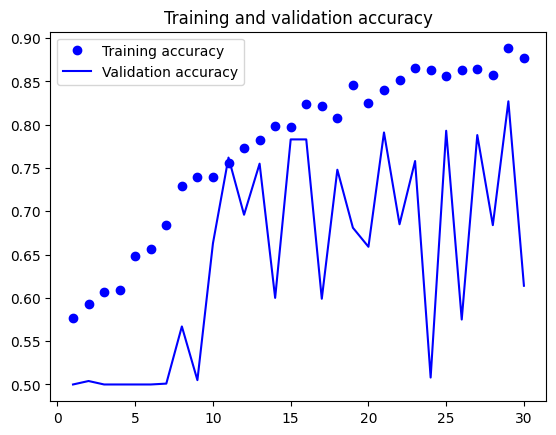

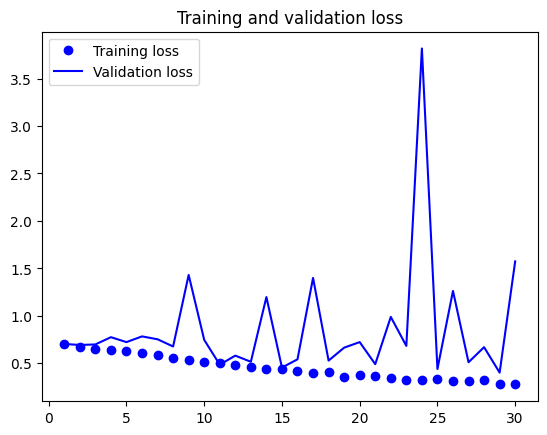

In [62]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [63]:
test_model = keras.models.load_model("Xception_catsvdogs.h5") 
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 27ms/step - loss: 0.4812 - accuracy: 0.8120
Test accuracy: 0.812


To get even better results, we need to do systematic hyperparameter tuning - where we cautiously change the values of hyperparamters in an attempt to increase the model's performance

Convnet interpretation:
Although deep neural nets are sort of like black boxes, and it is hard to present the feature maps they learn in human readable form,it is easier in convnets because the intermediate activations can be visualized and the features which contributed to the decision making of the neural network can be focussed.

There are three methods for interpretation of convnets:
1. Visualization of convnet outputs - intermediate activations
2. Visualization of convnet filters - the contribution of every filter to the final output
3. Visualization of heatmap activations for the output class probabilities.

Visualizing intermediate activations

In [2]:
from tensorflow import keras

In [3]:
model = keras.models.load_model(
"convnet_from_scratch_with_augmentation.keras")

2024-03-17 11:31:35.628893: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-17 11:31:35.628915: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-17 11:31:35.628922: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-17 11:31:35.628978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-17 11:31:35.629017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [5]:
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

In [6]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array,axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180,180))


In [7]:
print(img_tensor.shape)

(1, 180, 180, 3)


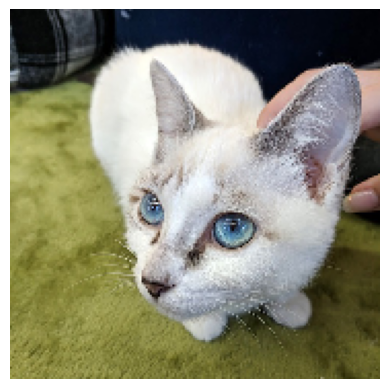

In [8]:
import matplotlib.pyplot as plt 
plt.axis("off") 
plt.imshow(img_tensor[0].astype("uint8")) 
plt.show()


In [9]:
from tensorflow.keras import layers
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D,layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs= layer_outputs)

In [10]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 96ms/step


2024-03-17 11:31:53.047796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


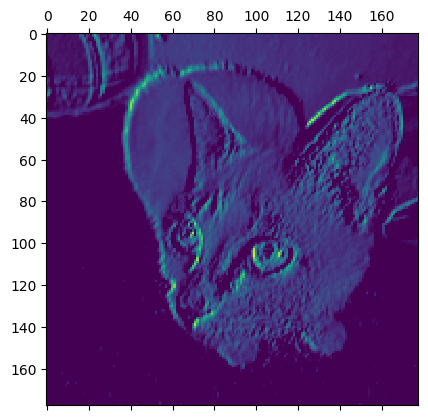

In [12]:
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[0, :, :, 9], cmap="viridis")


Each filter learns some characteristics of image like receptivity to colors, shapes, texture.

Visualizing every conv activation in the layers


In [20]:
len(activations)

9

In [22]:
%matplotlib inline

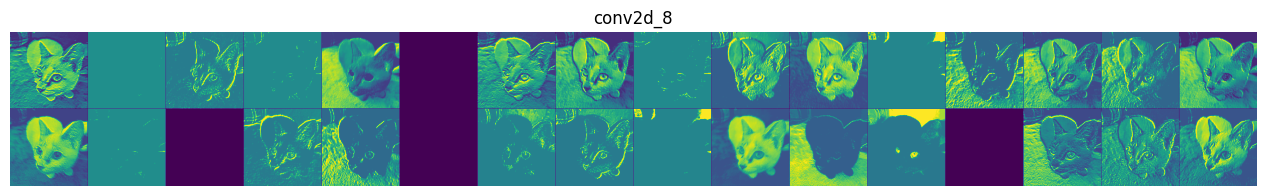

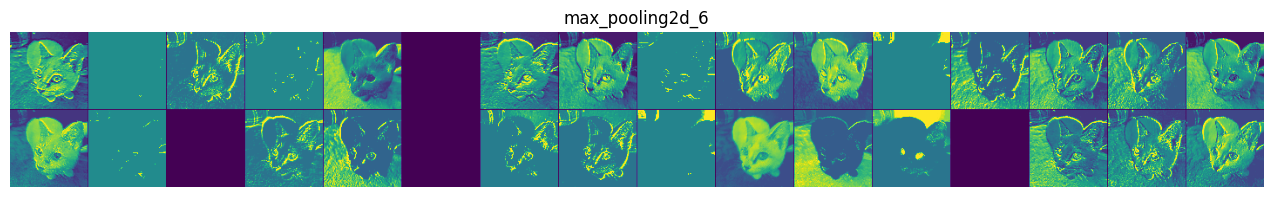

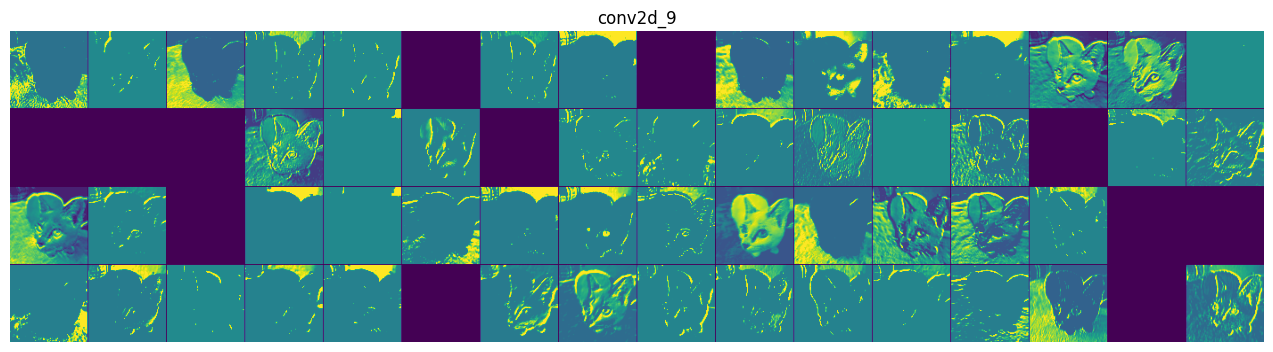

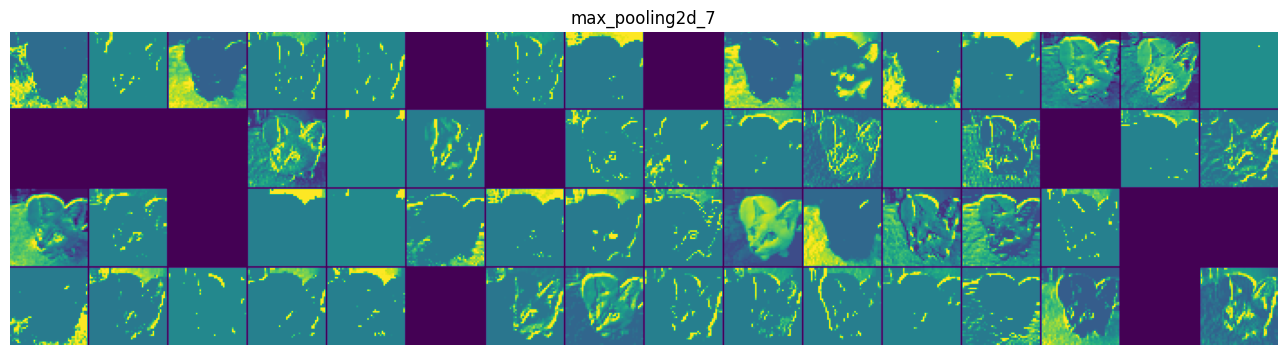

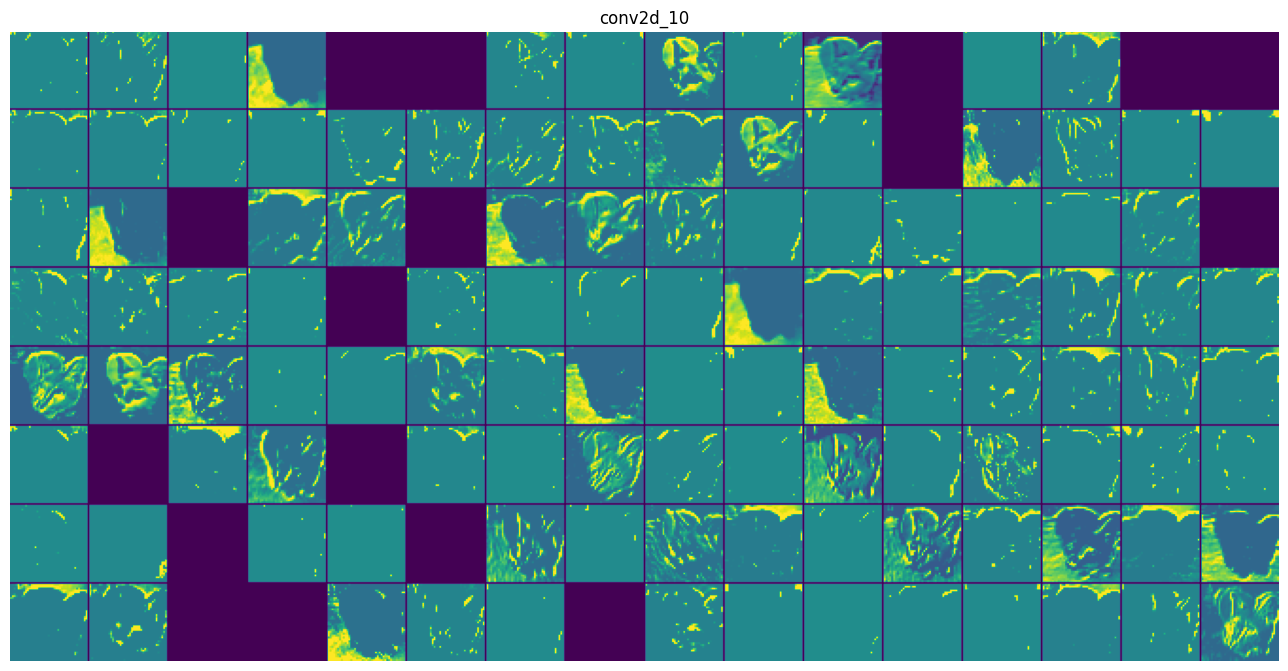

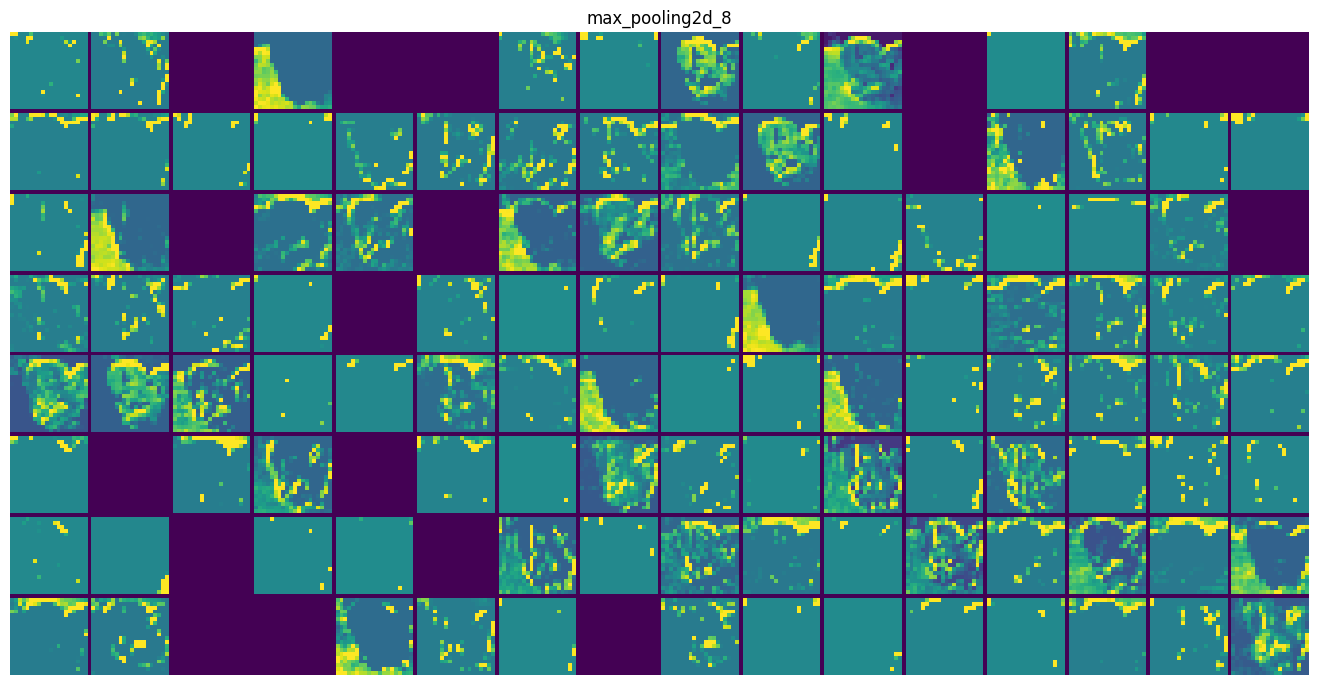

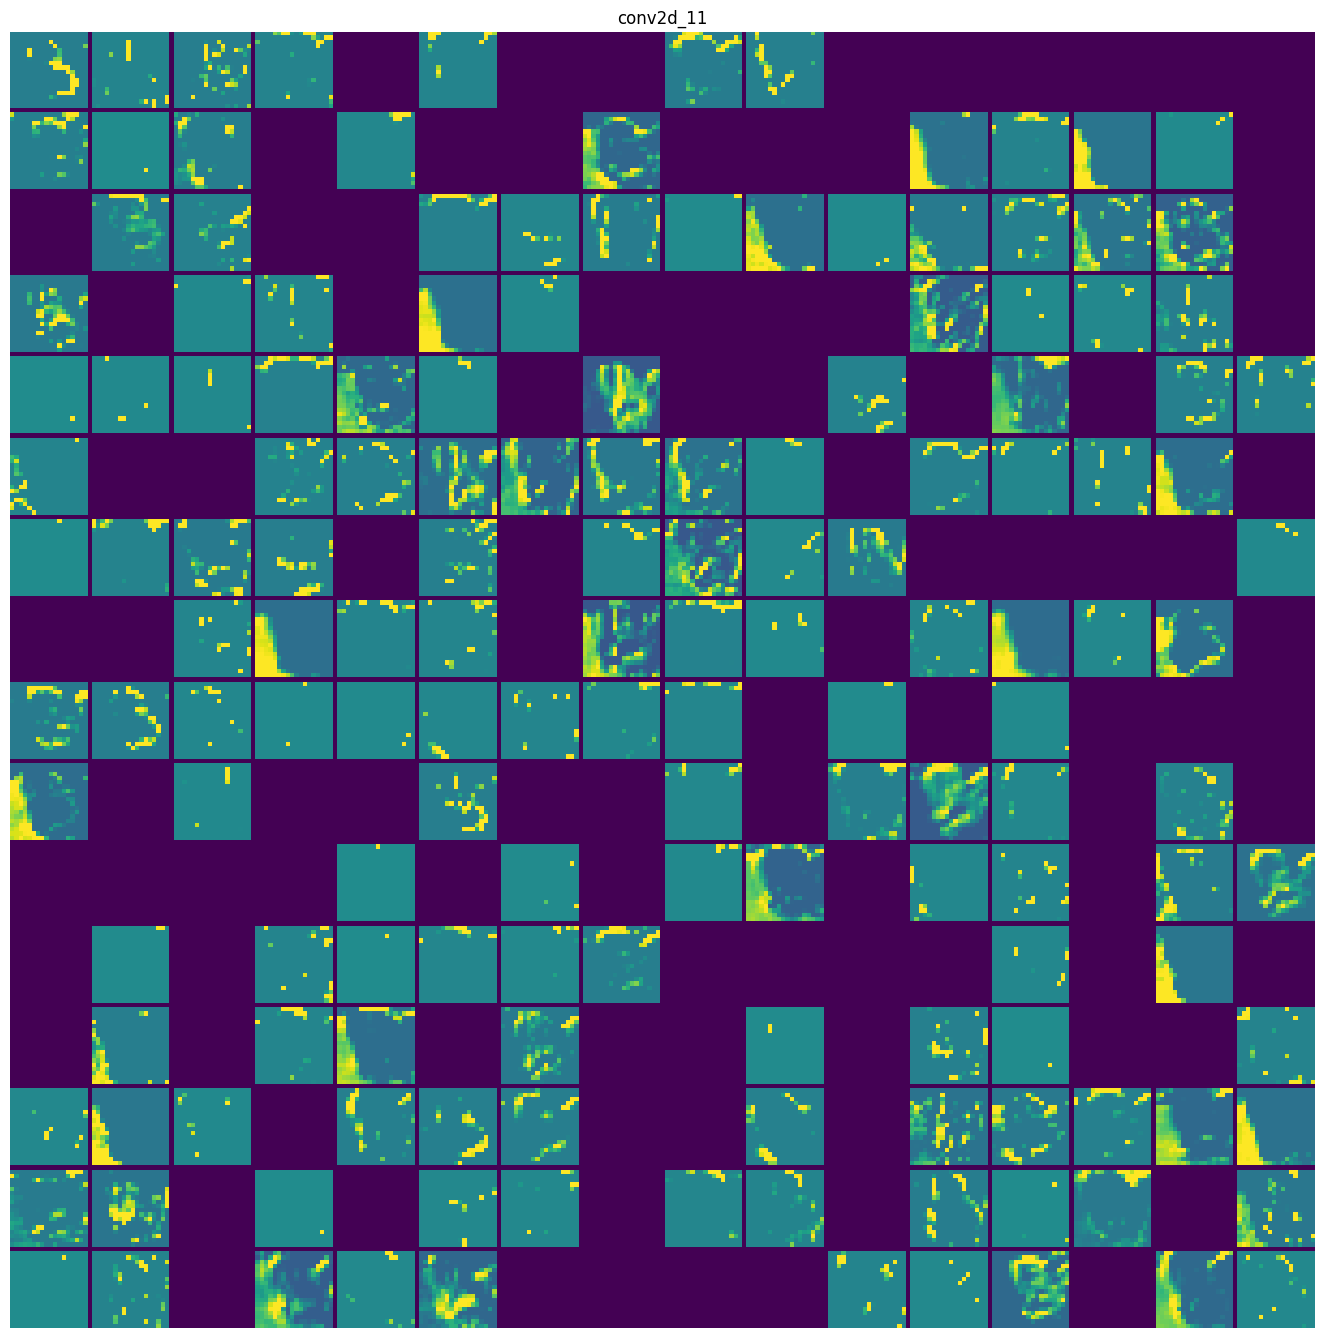

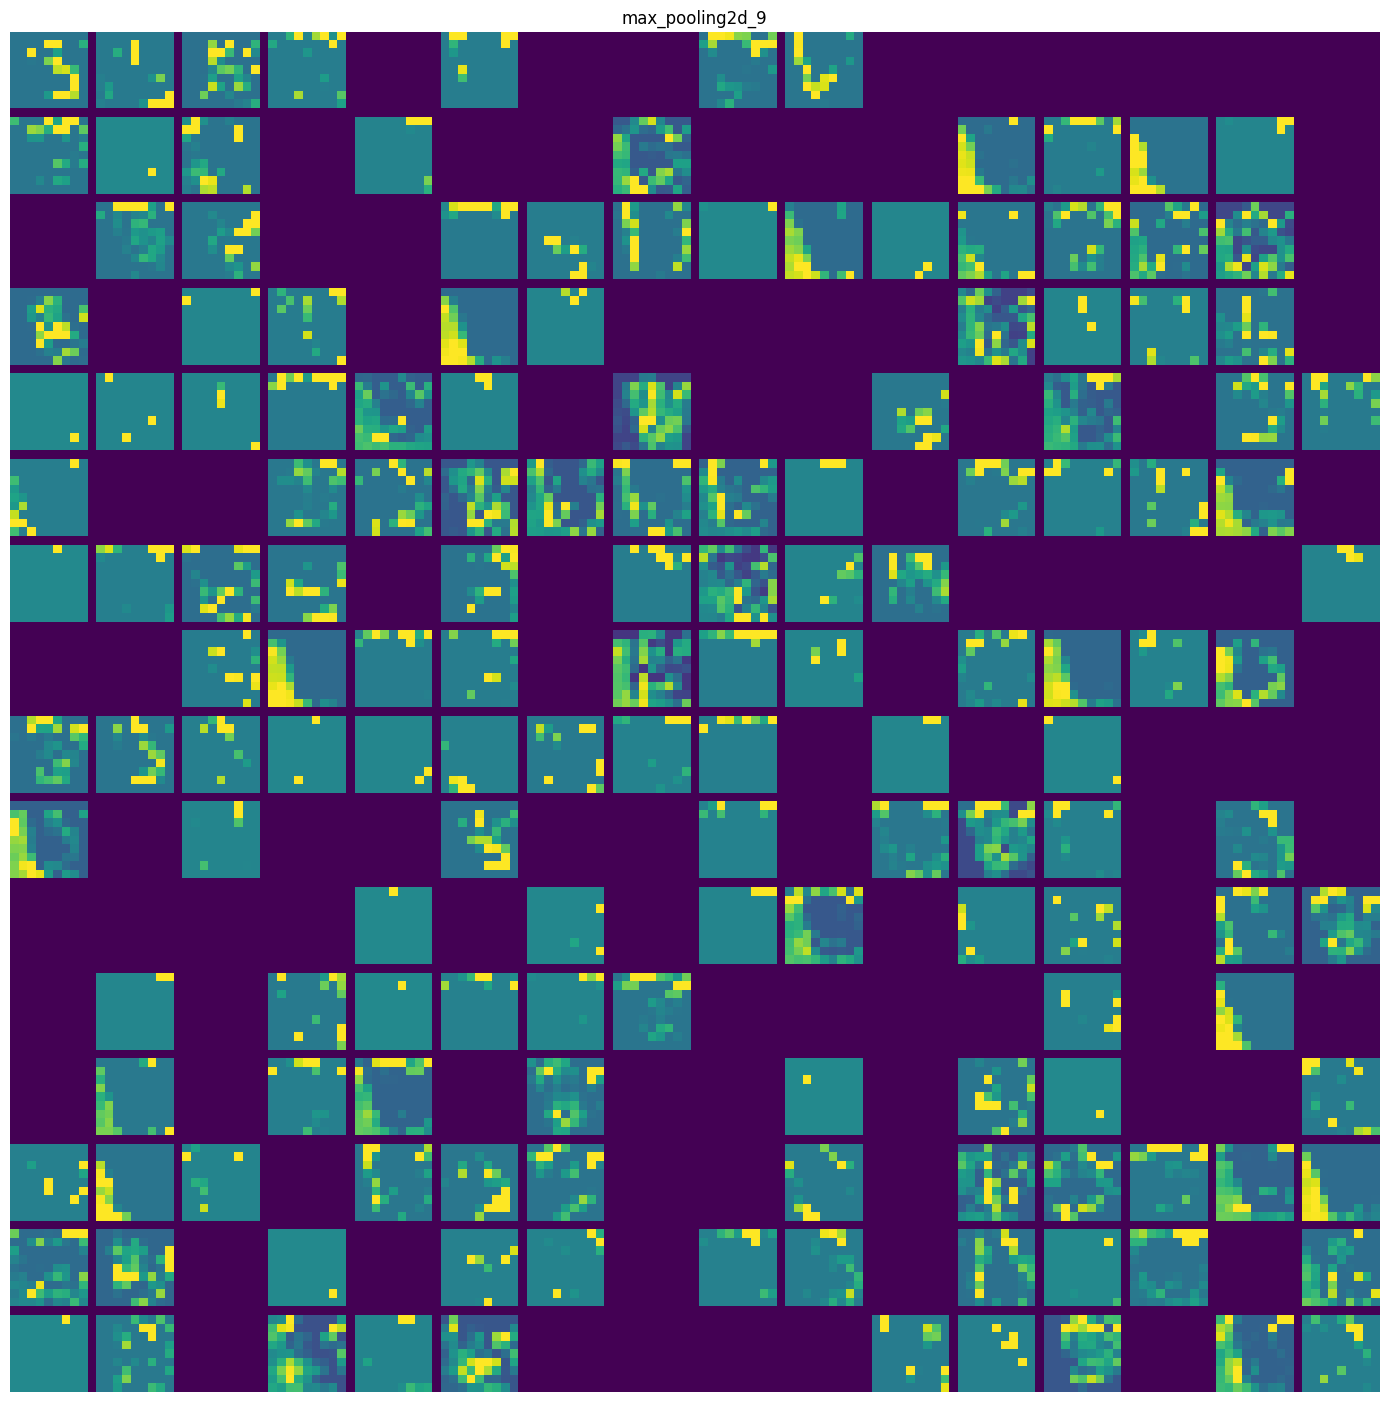

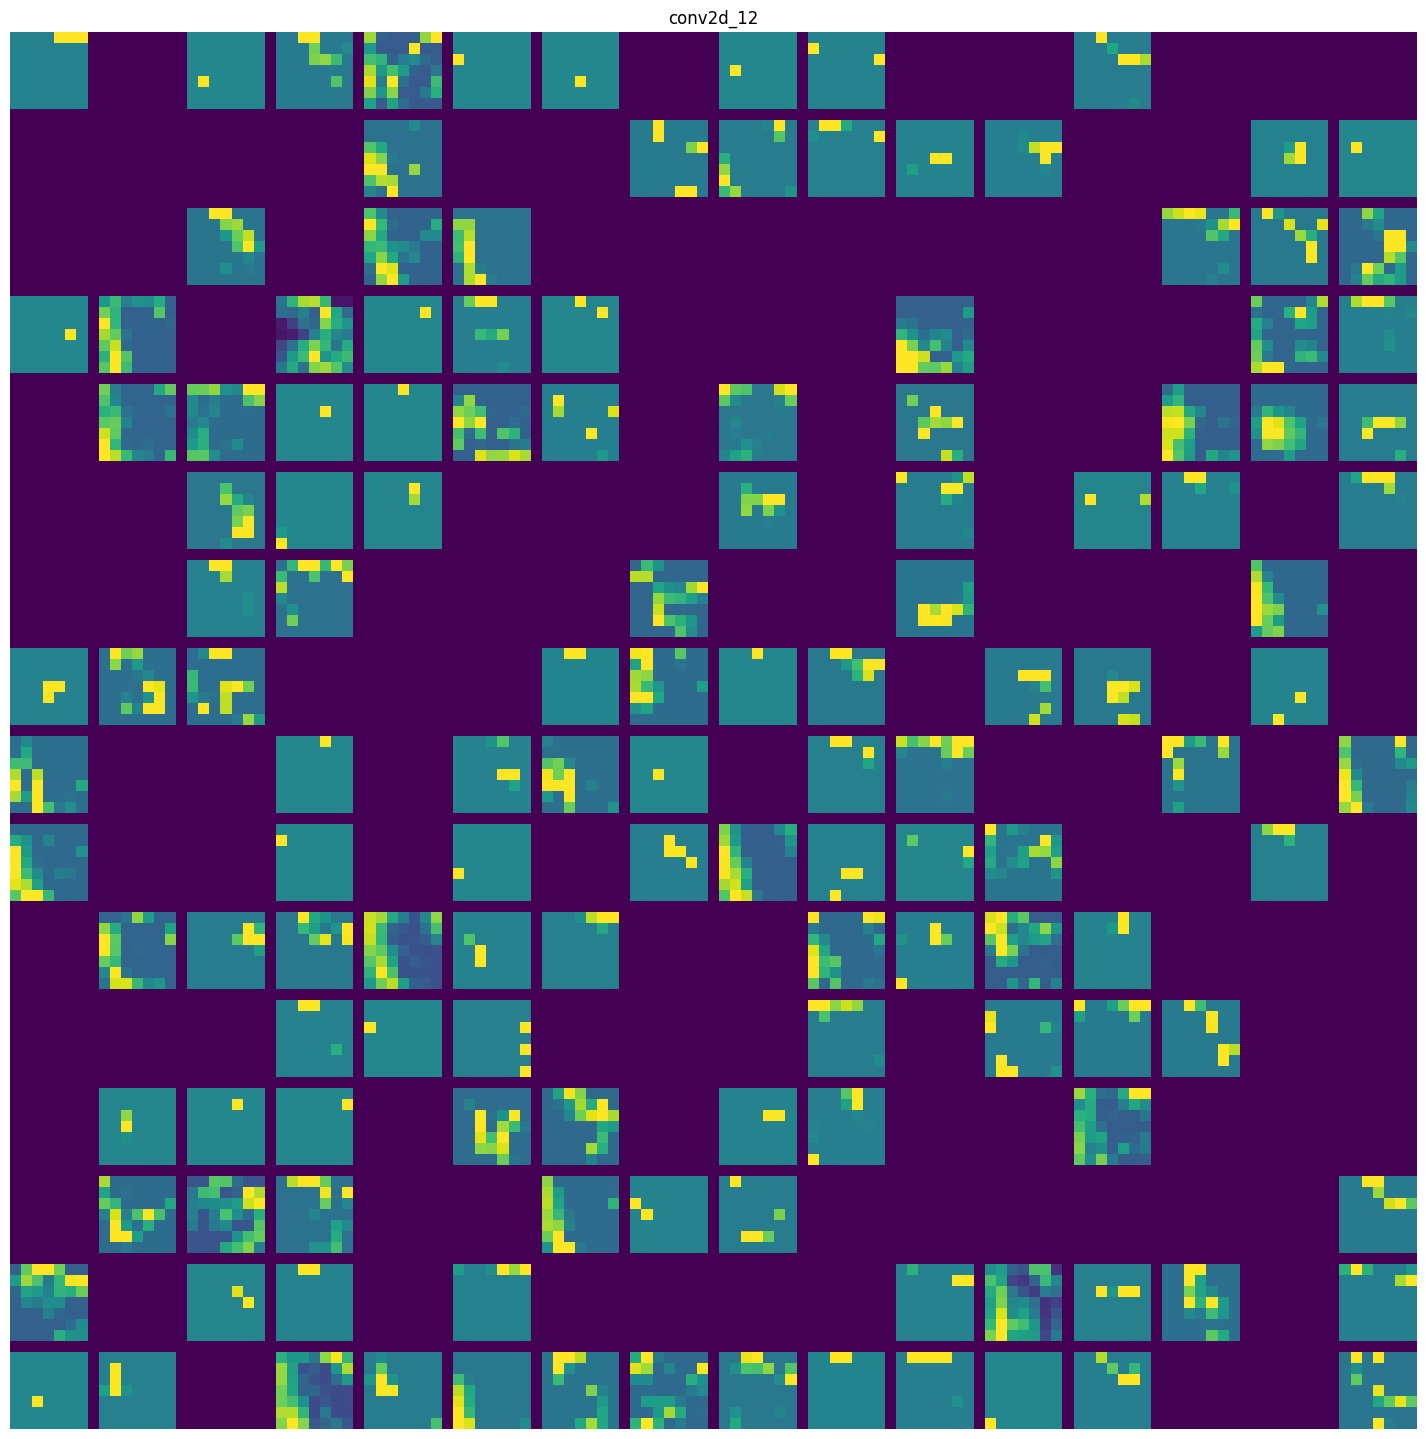

In [25]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size+1)*n_cols-1, images_per_row*(size+1)-1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col*images_per_row + row
            channel_image = layer_activation[0,:,:,channel_index].copy()
            if channel_image.sum()!=0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[
            col * (size + 1): (col + 1) * size + col,
            row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1./size

    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")





the first few layers have encoded less abstract features of the image like edges, color gradients, binary mask etc.these contain more information about the image
as we go deeper, visually it is harder to make sense, because the filters have learned features which are important for the task at hand like the output class dependednt. 
And in the deeper layers, many of the filters are not activated, meaning the input image has not activated the kernels.

Visualization of convnet filters :
to find out what each filter encodes, it is important to understand to which input image, the filter responds maximally to
This is done in the following way : 
starting with a blank image, the pixels are manipulated with gradient ascent with the objective of maximum activation to a certain filter

In [26]:
model = keras.applications.xception.Xception(
weights="imagenet",
include_top=False)

83683744/83683744 [==============================] - 24s 0us/step


we are interested in the convolution layers alone , so no need to include the classification layer on top.

In [28]:
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name
              )

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


the above model uses Functional API to create the model. so, intermediate layers can be easily extracted and inspected. 


In [29]:
#Example : replace the name with any other valid layer to extract its outputs
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
#new model with current layer as output layer
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [30]:
activation = feature_extractor( keras.applications.xception.preprocess_input(img_tensor)
)

In [31]:
img_tensor.shape

(1, 180, 180, 3)

In [32]:
import tensorflow as tf
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:,2:-2,2:-2,filter_index] # to crop the border and padding issues
    return tf.reduce_mean(filter_activation)


model.predict(x) : processes the input in batches (accepts batch_size as argument) and return output in batches.
but cannot retrive gradients in case a low-level gradient update is done.scales well with larger arrays
model(x) : does not processin batch. but paves way to update gradients. 
if running inference, prefer model.predict(x)


In [33]:
@tf.function # decorator to speed up - graph compilation instead of eager execution
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image) # in tensorflow, tf.Variable is by default watched in tape, to watch others, tape.watch is explicitly called
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss,image)
    grads = tf.math.l2_normalize(grads) # for smooth convergence, the gradients are normalized with l2 norm. this makes sure that the gradients are in the same range
    image += grads*learning_rate
    return image

In [34]:
image_width= 200
image_height = 200
def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(minval=0.4, maxval=0.6,shape=(1,image_width,image_height,3)) # Xception expects input image in shape [0,1]
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [38]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    image = image[25:-25, 25:-25, :] # crop the border pixels and focus on the central pixels
    return image

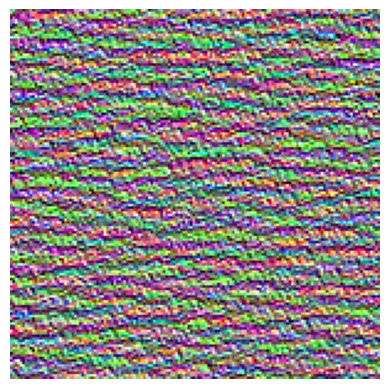

In [37]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

the second filter seems to get activated by horizontal lines and is able to detect wavy pattern
we shall now try to get these maps for all the filters.

In [39]:
images = []
for i in range(64):
    print(f"Processing filter {i}")
    image = deprocess_image(generate_filter_pattern(filter_index=i))
    images.append(image)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

In [40]:
margin = 5
n = 8
cropped_width = image_width - 25 * 2 
cropped_height = image_height - 25 * 2
width = n * cropped_width + (n - 1) * margin 
height = n * cropped_height + (n - 1) * margin 
stitched_filters = np.zeros((width, height, 3))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


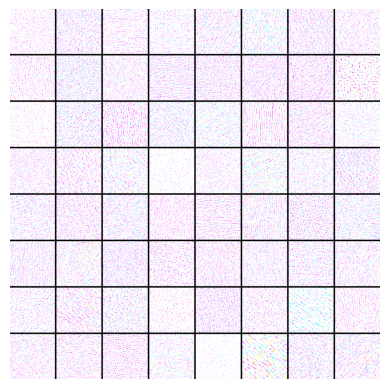

In [44]:
for i in range(n):
    for j in range(n):
        image = images[i*n+j]
        row_start = (cropped_width + margin) * i
        row_end = (cropped_width + margin) * i + cropped_width 
        column_start = (cropped_height + margin) * j
        column_end = (cropped_height + margin) * j + cropped_height
        stitched_filters[
    row_start: row_end,
    column_start: column_end, :] = image
plt.figure()

plt.grid(False)
plt.axis("off")
plt.imshow(stitched_filters)

The convnet has filter which respond to certain patterns and features of an input image. so,the input image is simply expressed as linear combination of this filters justlike how fourier transform enodes any signal as a combination of sine / cosine functions. the convnet filters get increasingly complex as we go deeper encoding complex patterns thereby able to learn abstract patterns

The next method which aids in convnet interpretability is visualization of heatmap of class activation 
Finding which part of the input image led the convnet to arrive at output decision - like the predicted class.
This helps in debugging in case the model predicts the wrong class. The category of studying class activation is called Class Activation Map (CAM) visualization.

CAM is a 2d grid of scores for an individual class output computed at every input location in the image,indicating how important each image location is for determing that class output. 

In [45]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 23s 0us/step


In [46]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [47]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

733657/733657 [==============================] - 1s 2us/step


In [48]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size) 
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array) 
    return array

In [49]:
img_array = get_img_array(img_path, target_size=(299, 299))

In [50]:
img_array.shape

(1, 299, 299, 3)

In [51]:
#run the pretrained network on the input image
preds = model.predict(img_array)
preds.shape

1/1 [==============================] - 2s 2s/step


(1, 1000)

Just like the image net dataset, it is a 1,1000 vector containing probability scores for 1000 classes
There is a keras utility function to print the top 3 classes

In [52]:
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 1us/step
[('n02504458', 'African_elephant', 0.8699266), ('n01871265', 'tusker', 0.07696868), ('n02504013', 'Indian_elephant', 0.023537247)]


In [53]:
print(np.argmax(preds[0]))

386


Now we construct a model which takes the input image and gives out the final convolution layer's outputs. i.e the final 
channels which are then hooked to a densely connected network which produce 1,1000
the idea is to consturct another model with this as input and model output as output and find which channel contributes more towards the correct output and project it back to input image.

In [54]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
"avg_pool",
    "predictions",
]

In [55]:
last_conv_layer = model.get_layer(last_conv_layer_name) 
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [56]:
print(last_conv_layer.output.shape)

(None, 10, 10, 2048)


In [57]:
#creating second model
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name) (x)
classifier_model = keras.Model(classifier_input, x)

In [58]:
x.shape

TensorShape([None, 1000])

In [59]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    print(preds.shape)
    top_class_channel = preds[:,top_pred_index]
    print(top_class_channel.shape)
grads = tape.gradient(top_class_channel, last_conv_layer_output)


(1, 1000)
(1,)


In [60]:
grads.shape

TensorShape([1, 10, 10, 2048])

In [61]:
pooled_grads = tf.reduce_mean(grads, (0,1,2))
pooled_grads.shape

TensorShape([2048])

In [62]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)


In [63]:
heatmap.shape

(10, 10)

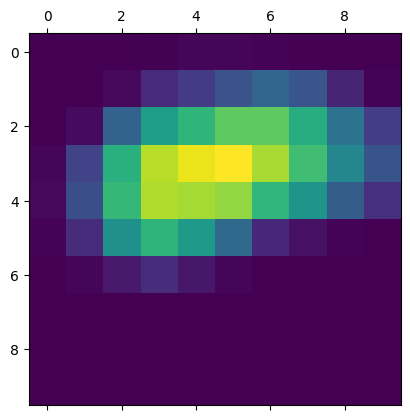

In [64]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

let us superpose this activation map on the input image to determine which image part contributed to this class.
Remember that the convolution filter encodes the spatial aspect of the image as well.

In [77]:
import matplotlib.cm as cm
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255*heatmap)
#print(heatmap)
jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]

jet_heatmap = jet_colors[heatmap]



/var/folders/pn/41l3cmvn0llckvh459j67qcw0000gn/T/ipykernel_976/3982917414.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [69]:
jet_heatmap = keras.utils.array_to_img(jet_heatmap) 
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0])) 
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

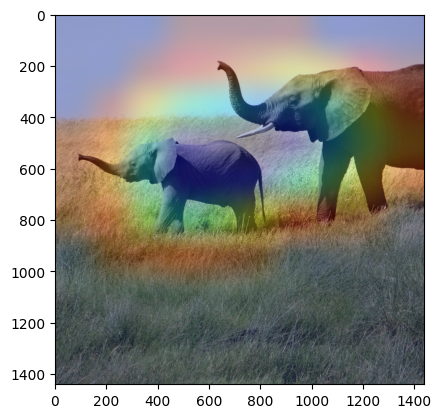

In [78]:
plt.imshow(superimposed_img)